# Session 3: Downstream scRNAseq analysis tools

## Google colab setup

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip install --quiet scrnatools
    !pip install --quiet scvi-colab
    from scvi_colab import install
    install()
    from google.colab import drive
    drive.mount("/content/gdrive")

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


INFO:lightning_fabric.utilities.seed:Global seed set to 0


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import scrnatools as rna
import scanpy as sc
import pandas as pd
import numpy as np
import scvi

## Data import

In [3]:
adata = sc.read("/content/gdrive/MyDrive/scrnaseq-course/data/scRNAseq_tutorial_thymus_data.h5ad")
model = scvi.model.SCVI.load("/content/gdrive/MyDrive/scrnaseq-course/data/scRNAseq_tutorial_thymus_data_scVI_model", adata=adata)

INFO     File /content/gdrive/MyDrive/scrnaseq-course/data/scRNAseq_tutorial_thymus_data_scVI_model/model.pt       
         already downloaded                                                                                        


## Dimensionality reduction

Representing cells in 2 dimensions based on their much higher (20,000) dimension gene expression is often a desireable first downstream analysis step. Two algoriithms are usually used for this purpose, uniform manifold approximation and projection (UMAP) and t-distributed stochastic neighbor embedding (TSNE). Theoretically UMAP is preferable as it attempts to preserve both global and local distances between cells while TSNE only preserves local distances (making distances on UMAPs technically more interpretable than those on TSNEs). However in practice you should *never* place much meaning on cell's relative position in either UMAPs or TSNEs as distilling 20 thousand dimensions into 2 dimensions will *always* distort distances between cells. In general, I have found UMAPs to be more useful when studying a dataset containing what you expect to be a lineage/related set of cells while TSNEs are generally more useful when you have a dataset containing many diverse, distinct cell types but both often have similar trends for the same dataset making them largely interchangeable in practice. Just remember that these serve *only* as visualization aids, and that biological insight is *always* required to validate and preliminary conclusions drawn from UMAPs/TSNEs.

### UMAP

In [4]:
sc.pp.neighbors(adata, use_rep="X_scVI") # Calculates each cell's nearest neighbors in scVI latent space
sc.tl.umap(adata, min_dist=0.3) # Uses the nearest neighbors in scvi-space to calculate UMAP coordinates for each cell
# The min_dist UMAP parameter can be tweaked to bring cells in the visualization closer together, but just leaving all the settings 
# at their defaults works as well

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


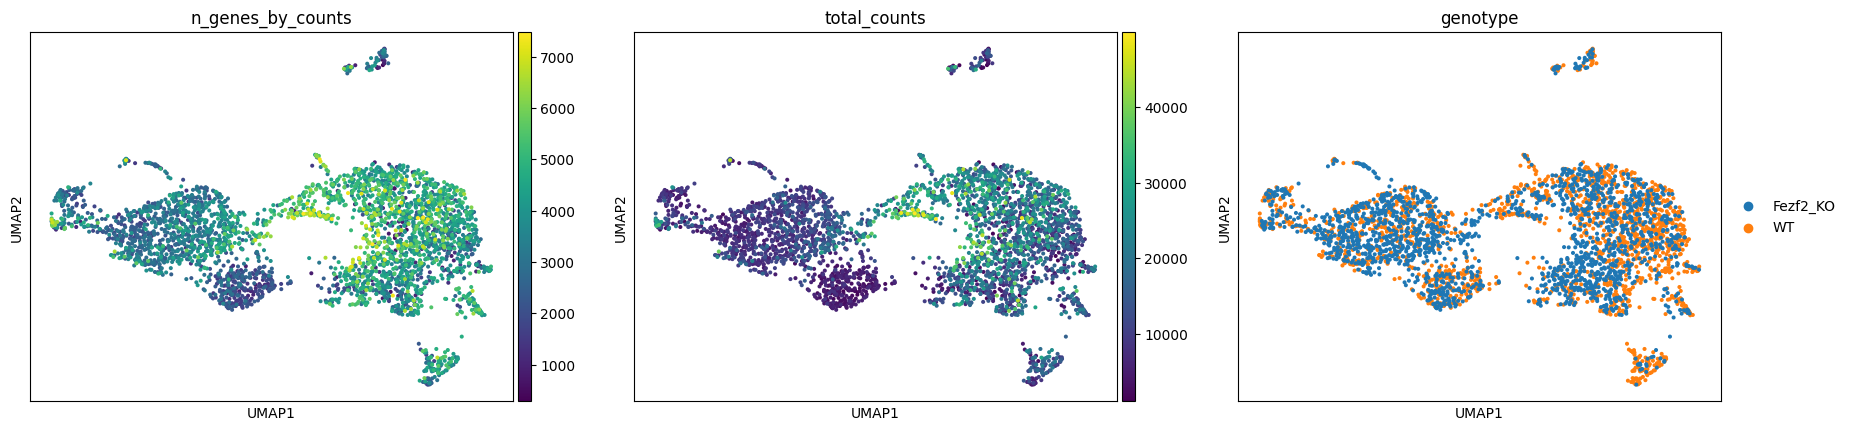

In [5]:
sc.pl.umap(
    adata,
    color=["n_genes_by_counts", "total_counts", "genotype"],
)

### TSNE

In [6]:
sc.tl.tsne(adata, use_rep="X_scVI") # calculates TSNE coordinates from scvi latent space

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


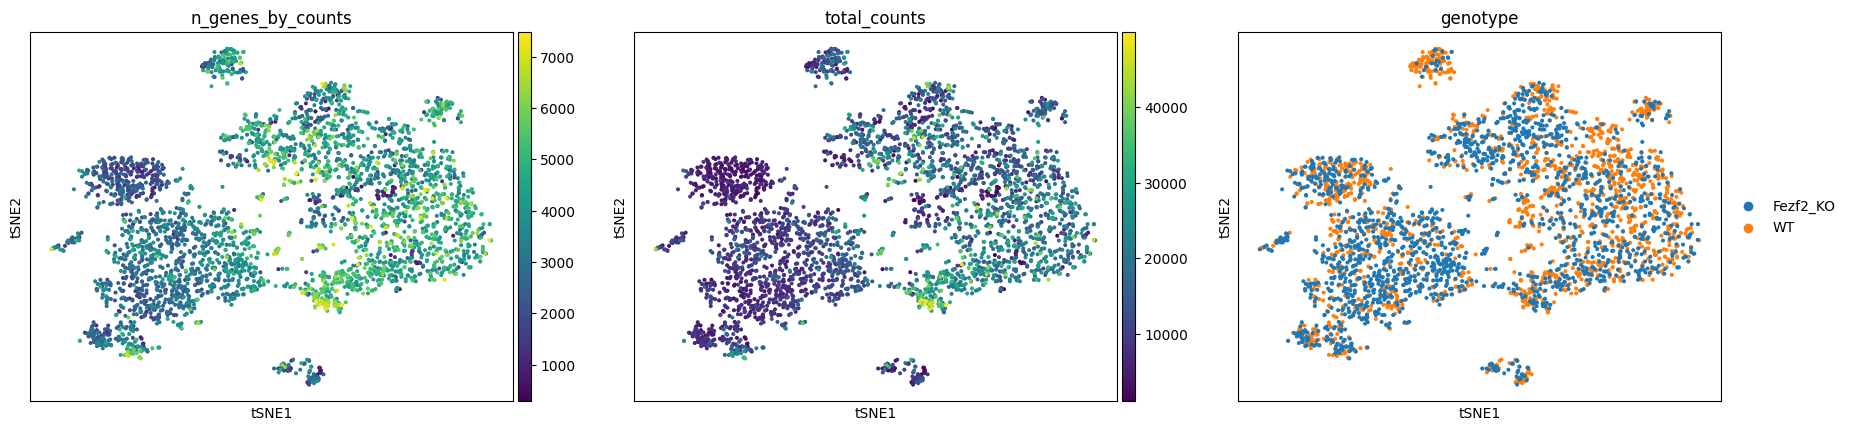

In [7]:
sc.pl.tsne(
    adata,
    color=["n_genes_by_counts", "total_counts", "genotype"],
)

## Leiden clustering

Next, groups of transcriptionally similar cells (based on their nearest neighbors in scVI latent space) are often broken into clusters corresponding to distinct cell types using the leiden unbiased clustering algorithm. The resolution parameter will break the cells up into more, finer clusters the larger the value, and you shouldd always stick to a value less than 1 to avoid overclustering. Picking a value for the resolution is more of an art than a science, but a good approach is to start around 0.5, then use feature plots of known marker genes for the broad cell types you expect to see in your data to increase or decrease this value until you see clustering results that largely seperates known biologically distinct populations.

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


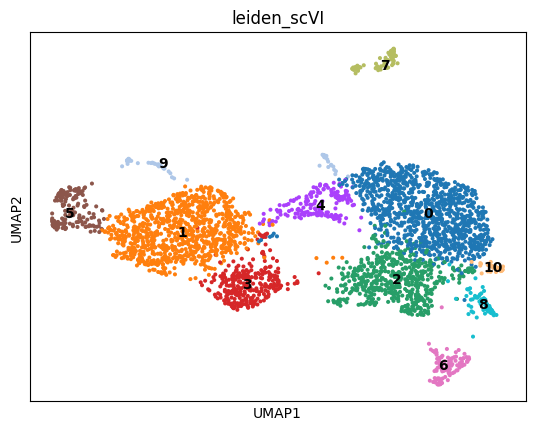

In [8]:
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.5)
sc.pl.umap(
    adata,
    color=["leiden_scVI"],
    legend_loc="on data",
)

## Cell type identification

In [9]:
geneList = ["Ptprc", "Tcf4", "Bcam",  "Psmb11", "Ccl21a", "Mki67", "Aire", "Fezf2", "Tspan8", "Ascl1", "Gp2", "Pou2f3", "Foxj1"]

### Feature plot

UMAP/TSNE feature plots are an indispendible tool for identifying cell types, removing contaminant clusters, and refining clustering results. I will typically plot gene expression on these feature plots with the colormaps clipped to the 1st and 99th percentile to prevent cells with outlier expression of that gene from skewing the colormap too much towards high/low values.

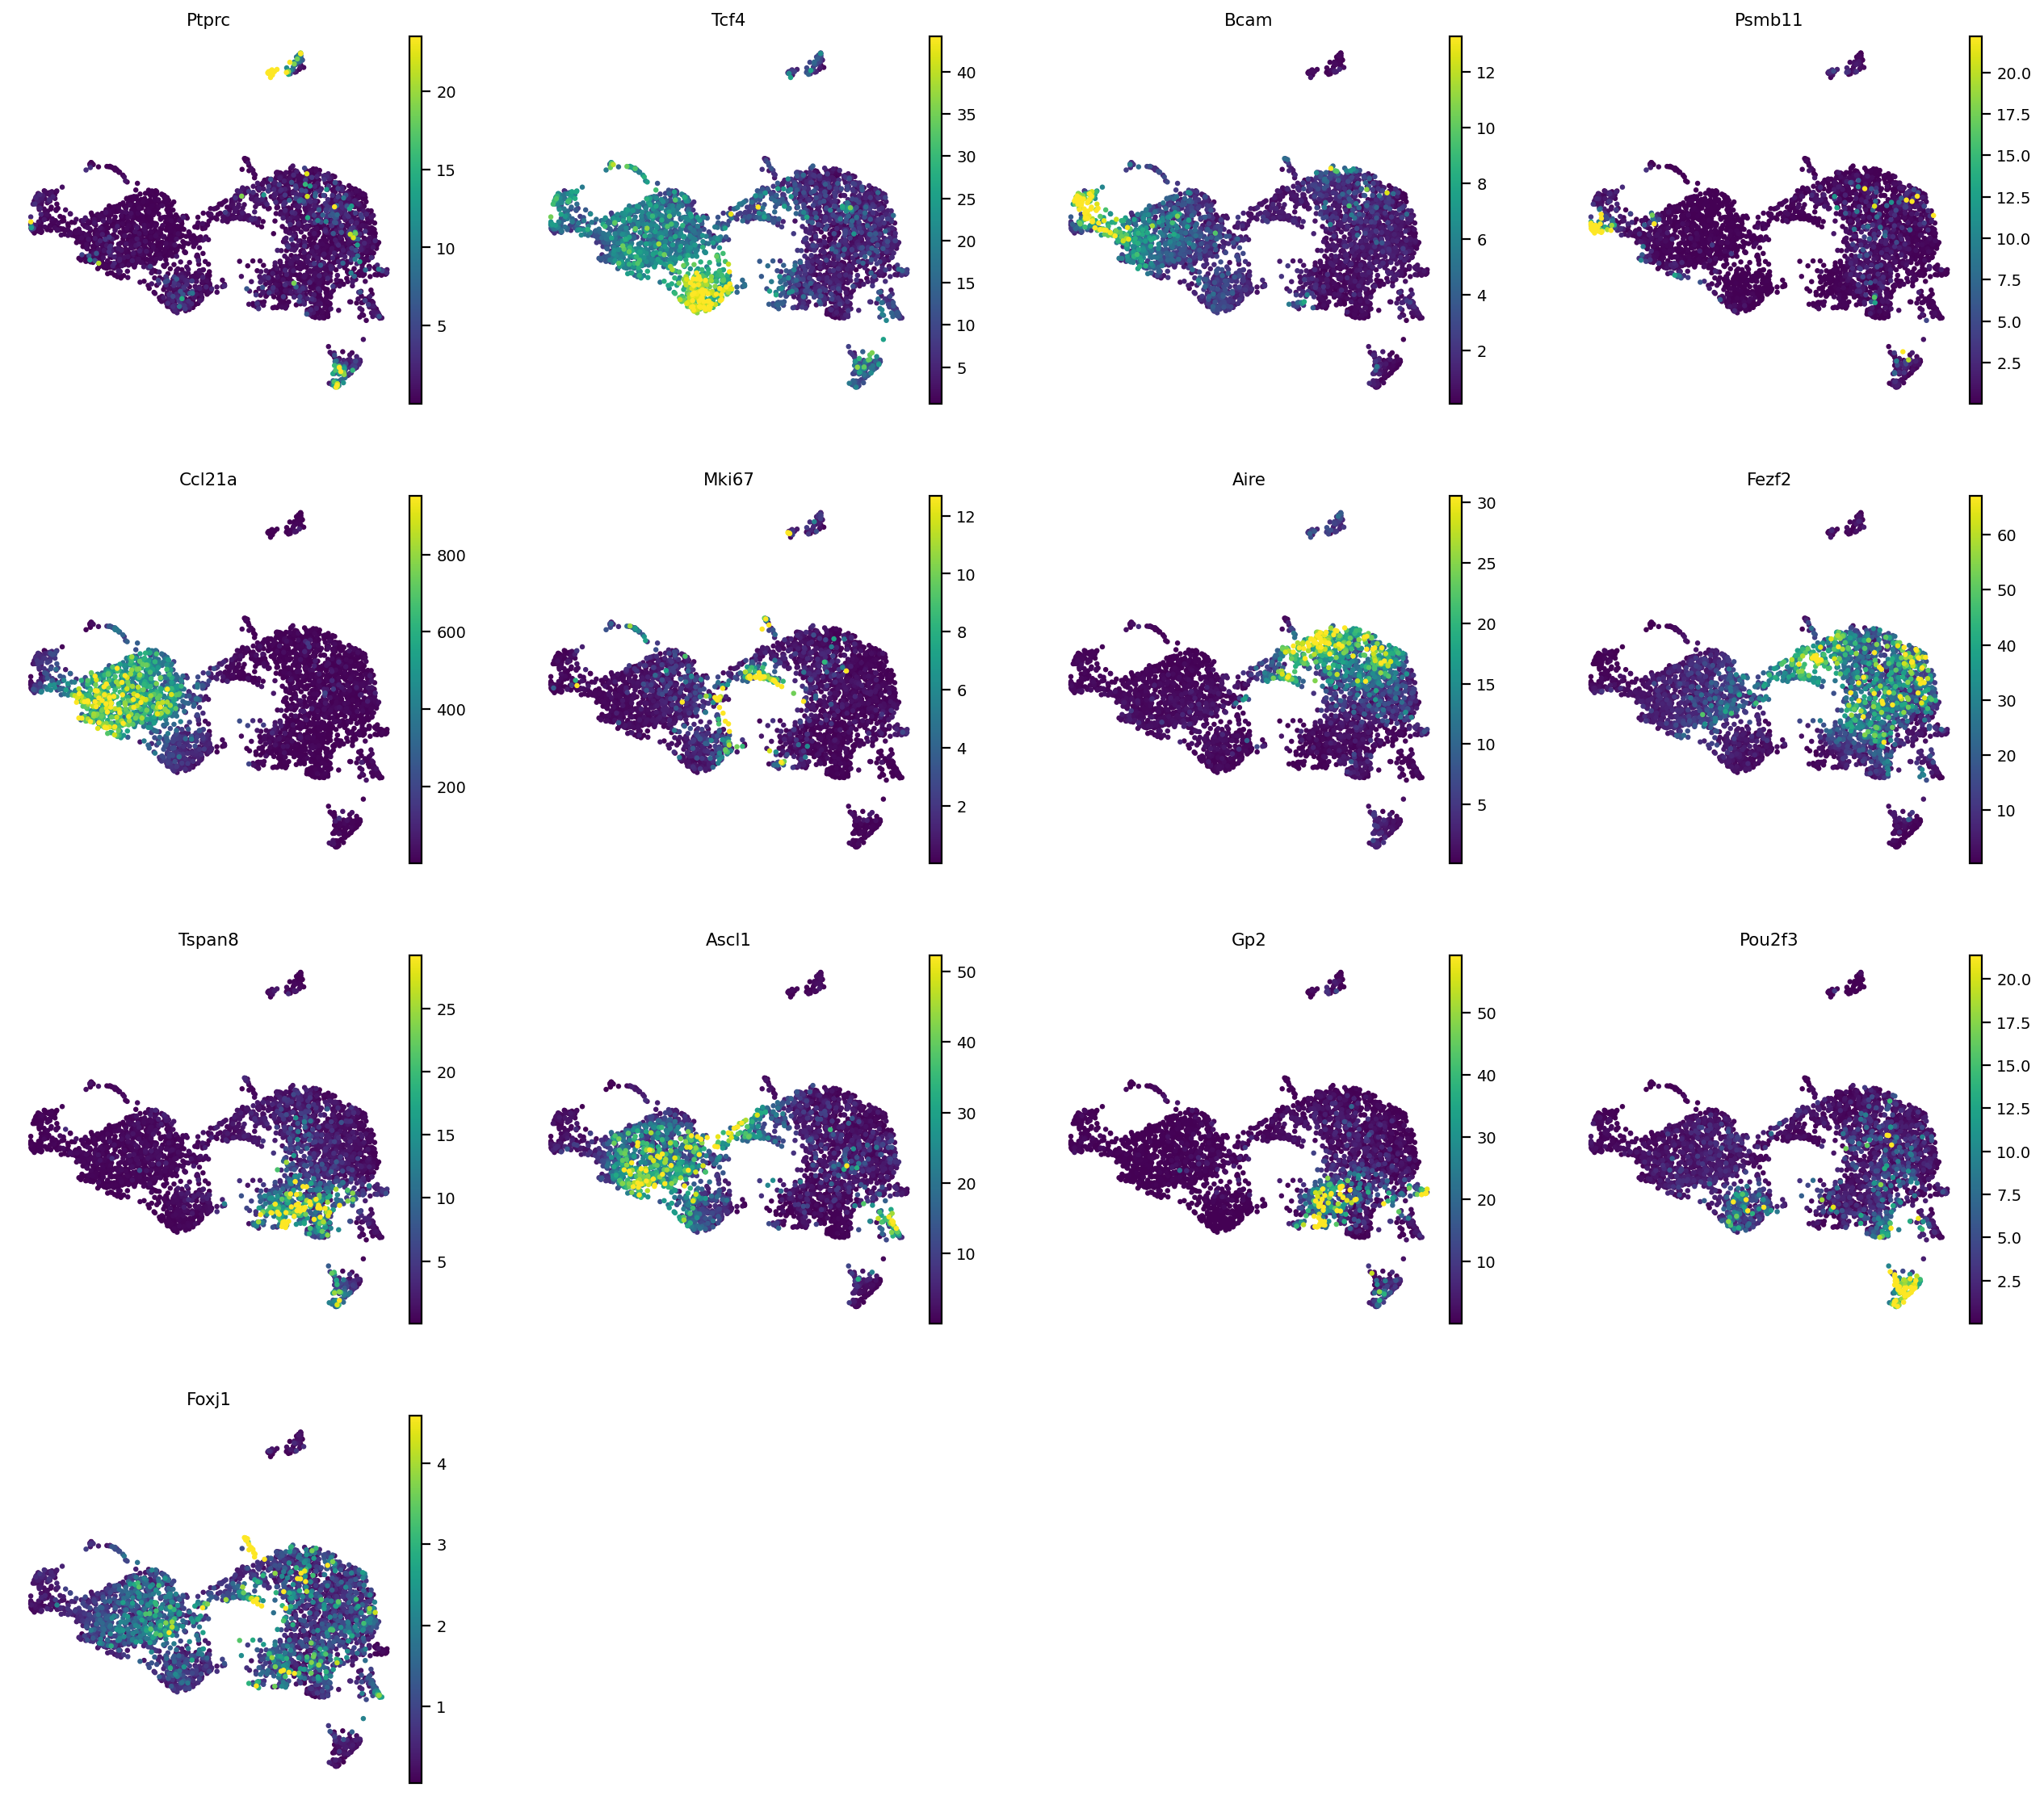

In [10]:
sc.settings.figdir = "analysis"
rna.pl.gene_embedding(
    adata,
    geneList,
    layer="scVI_normalized", # can be a layer (i.e. 'raw_counts') or 'X'
    figsize = (4, 4), # size of each panel
    dpi = 80, # resolution of figure to show
    dpi_save = 300, # resolution of figure to save
    min_quantile = 0.01, # the quantile of expression for a gene to set the minimum of the colorbar to
    max_quantile = 0.99, # the quantile of expression for a gene to set the maximum of the colorbar to
    use_rep = "X_umap", # the embedding coordinates in 'adata.obsm' to use
    save="_marker_genes_scvi_expression.png",
    cmap="viridis"
    # can also pass other arguments through to sc.pl.umap such as s, cmap, etc (see scanpy documentation)
)

### Remove contaminating populations

After a first round of clustering and feature plotting it is appropriate to remove clusters of cells you aren't interested in such as known
sort contaminants

In [11]:
adata = adata[~adata.obs.leiden_scVI.isin(["13", "10", "9", "14", "11"])]

### Recompute UMAP/clusters

Then you will need to create a new UMAP/TSNE and recluster based on only the cells of interest

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


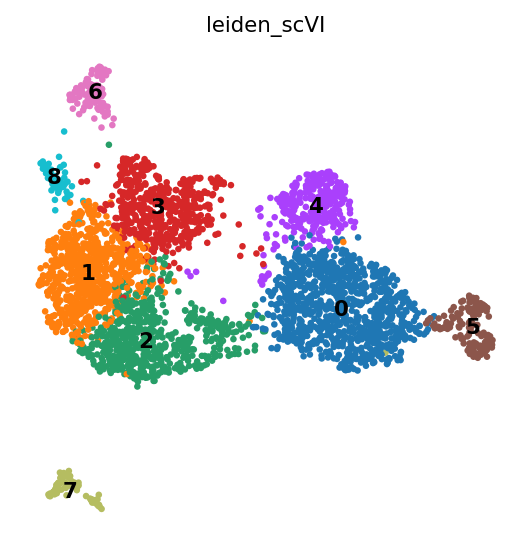

In [12]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)
sc.tl.tsne(adata, use_rep="X_scVI")
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.5)
sc.pl.umap(
    adata,
    color=["leiden_scVI"],
    legend_loc="on data",
)

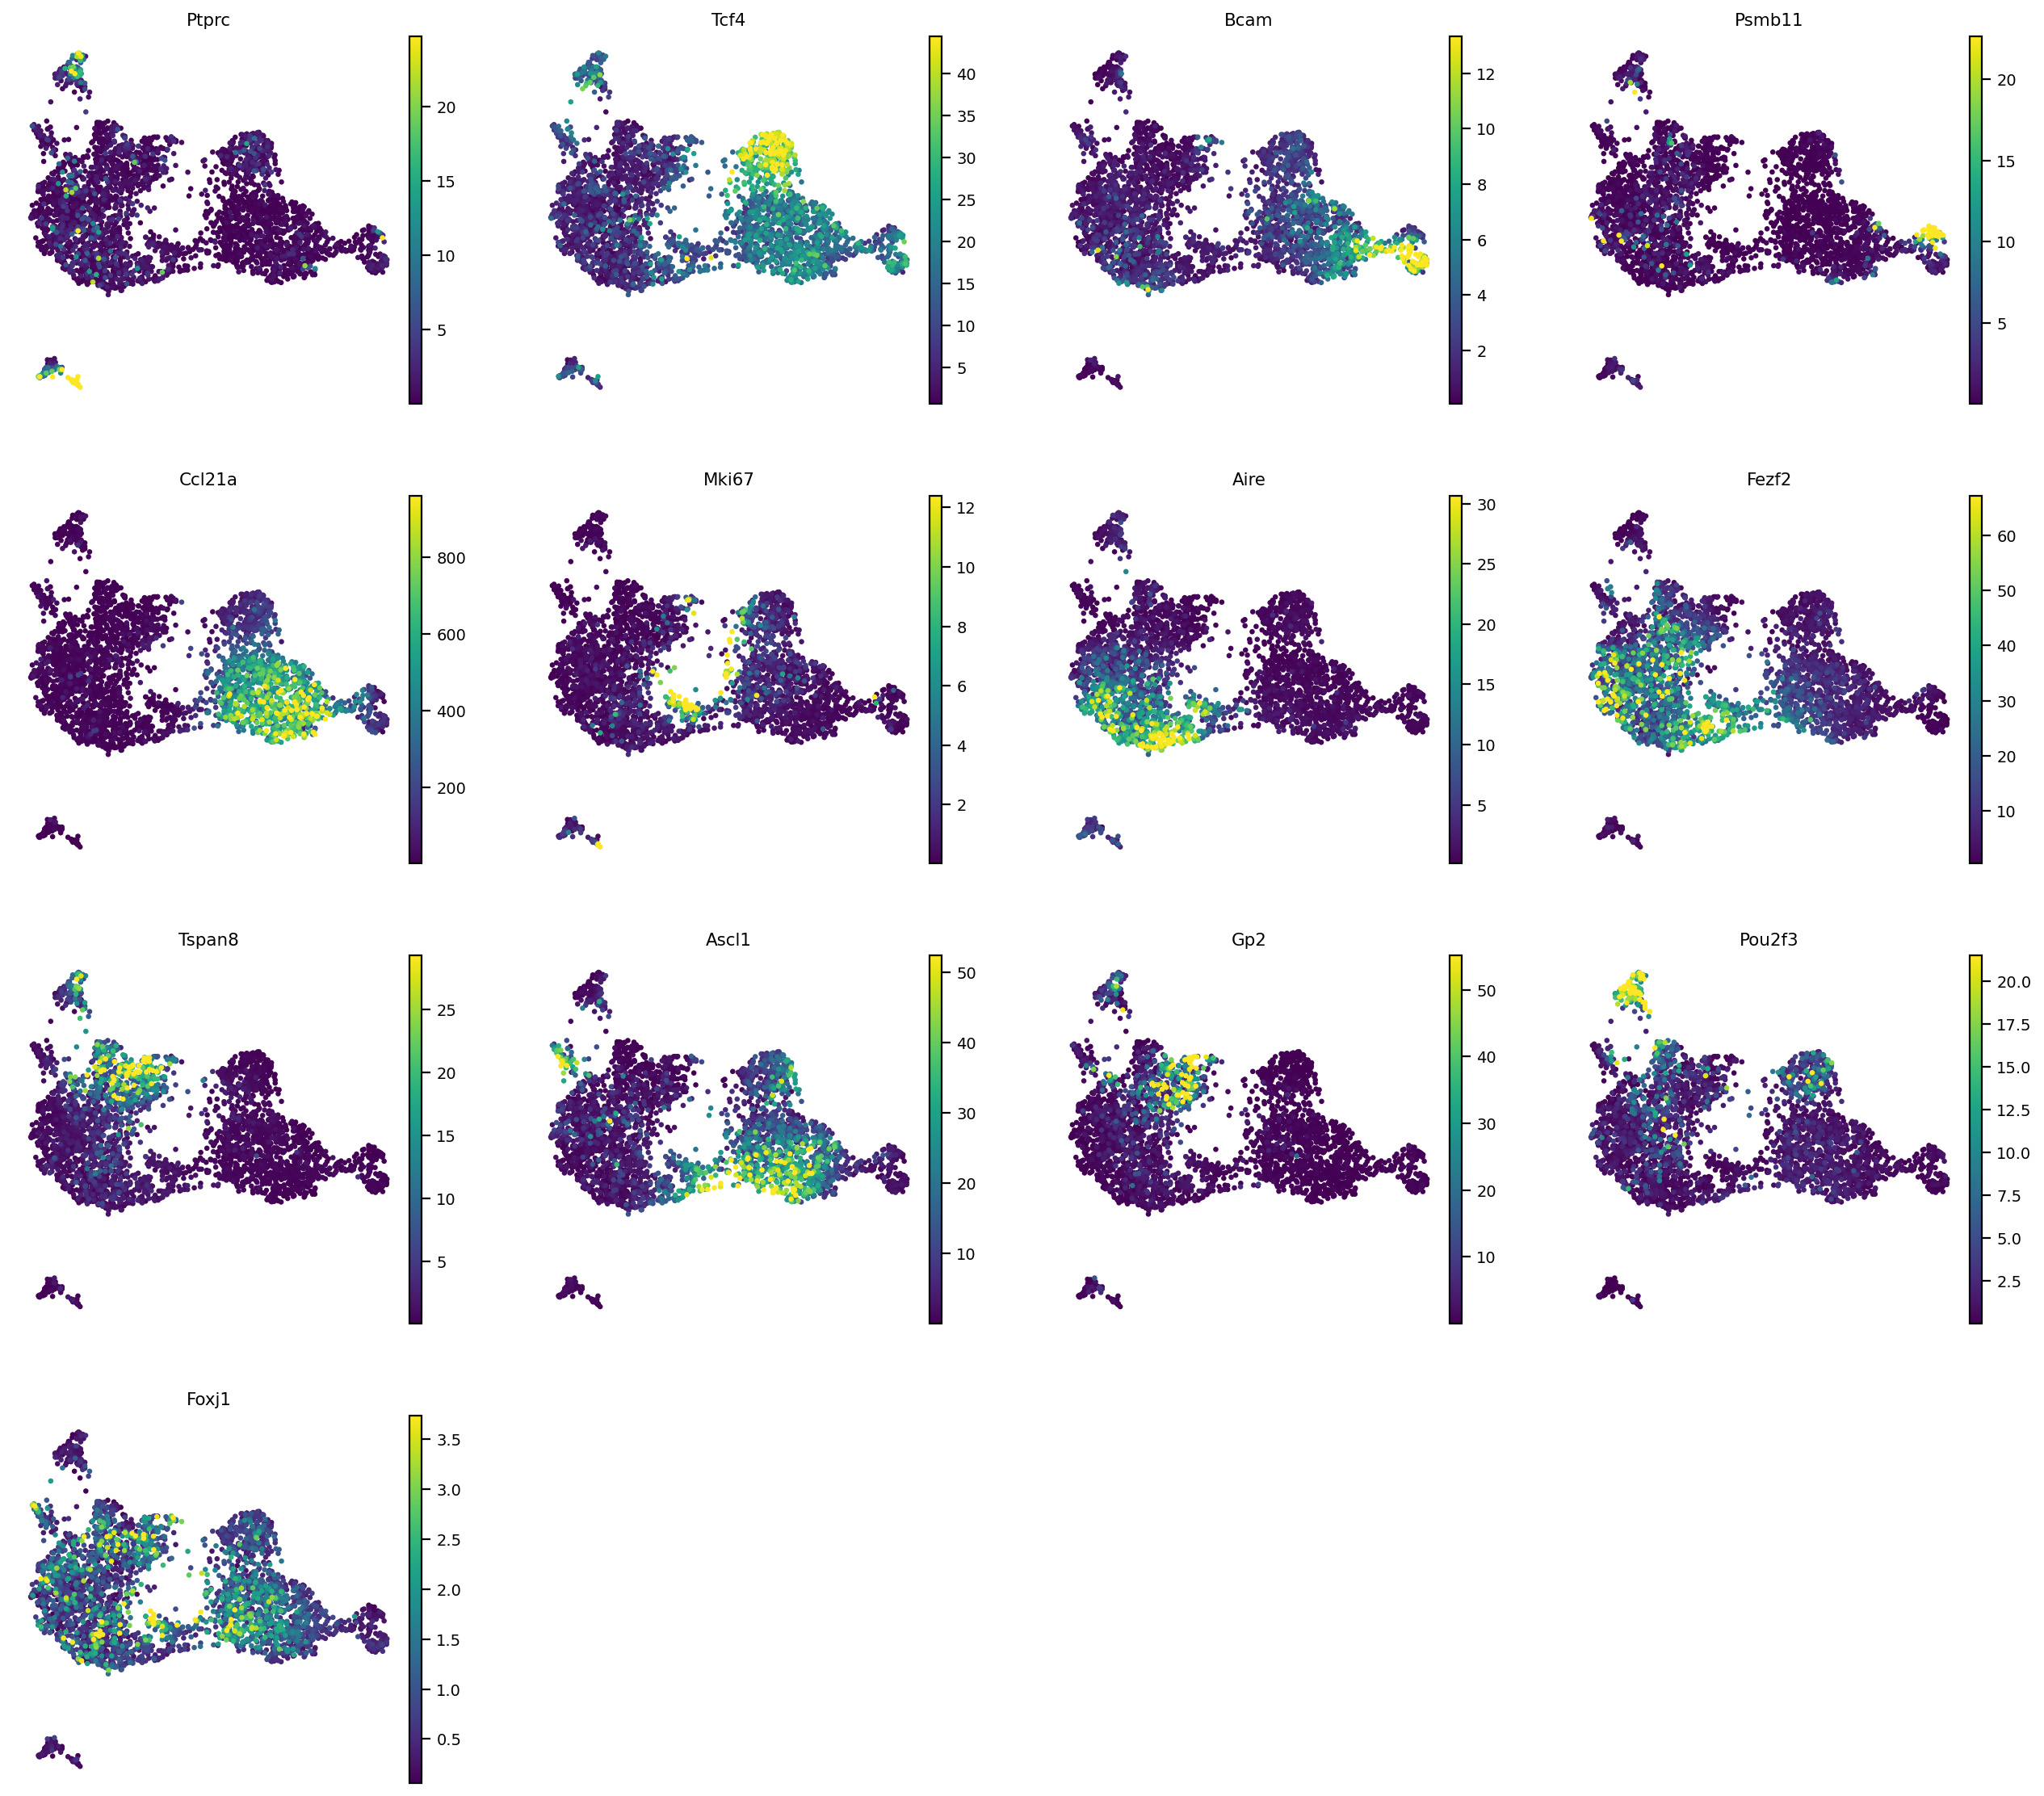

In [13]:
sc.settings.figdir = "analysis"
rna.pl.gene_embedding(
    adata,
    geneList,
    layer="scVI_normalized", # can be a layer (i.e. 'raw_counts') or 'X'
    figsize = (4, 4), # size of each panel
    dpi = 80, # resolution of figure to show
    dpi_save = 300, # resolution of figure to save
    min_quantile = 0.01, # the quantile of expression for a gene to set the minimum of the colorbar to
    max_quantile = 0.99, # the quantile of expression for a gene to set the maximum of the colorbar to
    use_rep = "X_umap", # the embedding coordinates in 'adata.obsm' to use
    save="_marker_genes_scvi_expression.png",
    cmap="viridis",
)

### Label cell types

Finally you can use known marker genes to annotate cell types in your dataset

In [14]:
# Make a copy of your leiden cluster IDs
adata.obs["cell_type"] = adata.obs.leiden_scVI.copy()

In [15]:
# Create a diictionary mapping each leiden cluster to a cell type based on marker genes
cellTypes = {
    "5": "cTECs",
    "1": "Ccl21a+ TECs",
    "3": "precursor TECs",
    "4": "TAC-TECs",
    "0": "Aire+ mTECs",
    "9": "Ciliated MCs",
    "8": "Microfold MCs",
    "7": "Neuroendocrine MCs",
    "2": "Cornefied MCs",
    "6": "Tuft cells"
}

In [16]:
# use the cell type dictionary to annotate cells
adata.obs.cell_type = adata.obs.cell_type.replace(cellTypes)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


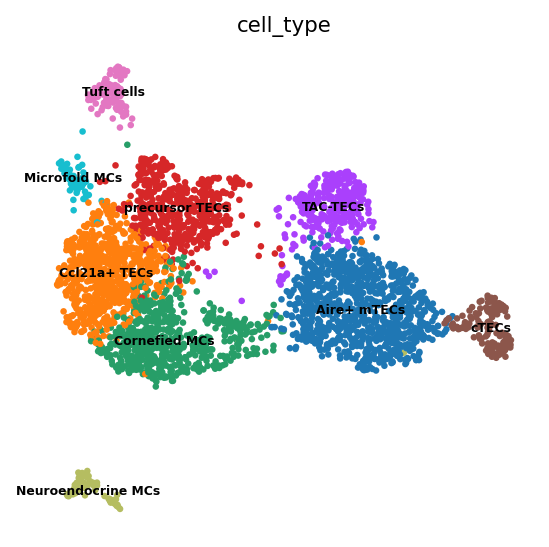

In [17]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    legend_loc="on data",
    legend_fontsize="xx-small",
)

### Heatmap

It can also sometimes be useful to create heatmaps displaying the average gene expression within each cluster, but here it is important to remember to z-score each gene's expression across clusters so that genes with higher average expression don't skew the colormap.

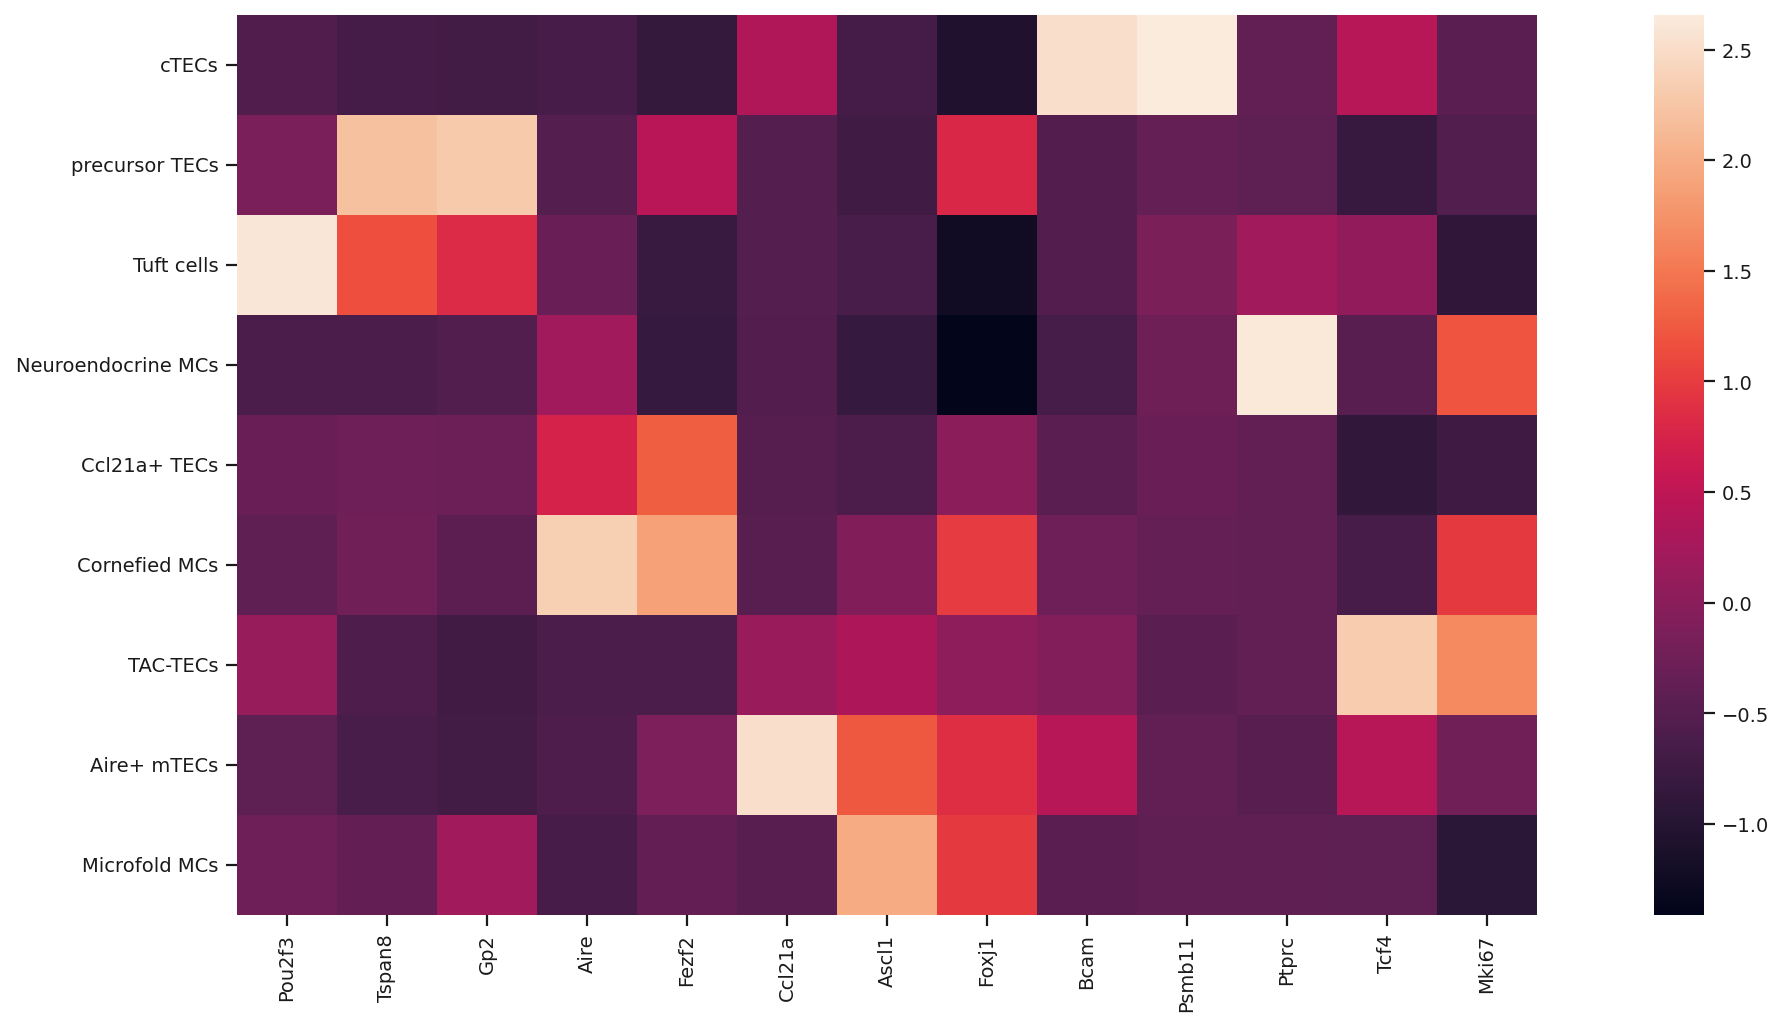

In [18]:
rna.pl.gene_heatmap(
    adata,
    geneList,
    obs_key="cell_type", # categorical grouping to display
    # obs_values=["DCs", "4", "T"], # values from obs key group to display
    layer="scVI_normalized", # can be a layer (i.e. 'raw_counts') or 'X'
    reverse_axis=False, # boolean to reverse x and y axes. Default False
    cell_size=50, # integer specifying the size of each cell in the heatmap
    dpi=80, # resolution of figure to show
    z_score=1,
    # save_path specifies path to save figure
    # can also pass other arguments through to sc.pl.umap such as s, cmap, etc (see matplotlib documentation)
)

### Violinplot

Finally, violinplots are useful for visualizing changes in a gene's expreession across samples (i.e. WT vs KO)

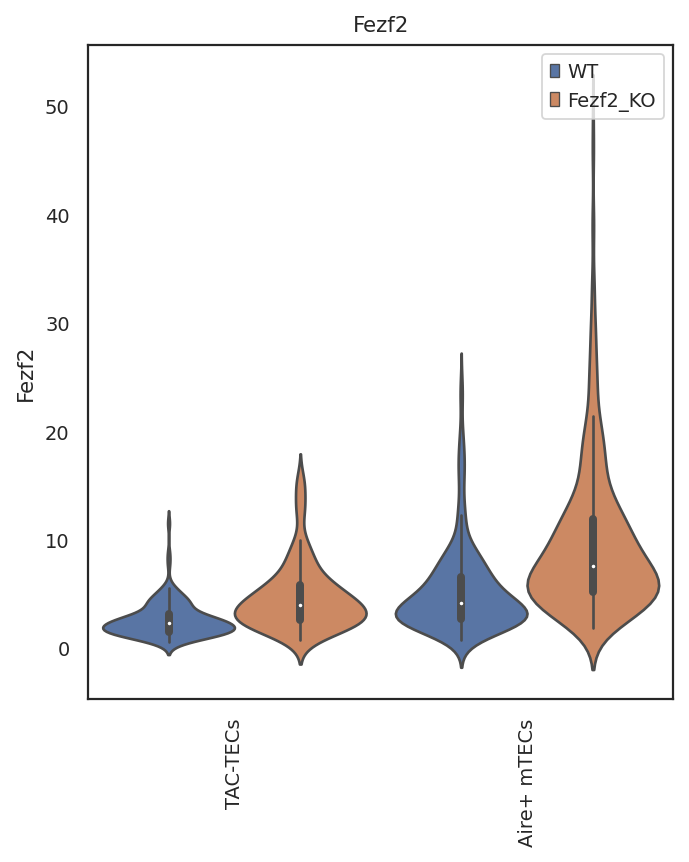

In [19]:
rna.pl.gene_violinplot(
    adata,
    ["Fezf2"],
    x_key="cell_type", # categorical grouping to display on the x axis
    x_values=["TAC-TECs", "Aire+ mTECs"],
    layer="scVI_normalized", # can be a layer (i.e. 'raw_counts') or 'X'
    hue_key="genotype", # categorical grouping to color the grouped violin plots by
    ncols=3, # number of columns for plots to display
    nrows=4, # number of rows for plots to display. ncols * nrows must be > or = total number of genes in geneList to display
    dpi=80, # resolution of figure
    # save_path specifies path to save figure
    # can also pass other arguments through to sc.pl.umap such as s, cmap, etc (see scanpy documentation)
)

## Differential expression

### Cluster-specific marker genes

Differrential gene expression analyses can be performed with a trained scVI model to identiffy marker genes for each of your clusters/cell types

In [20]:
deGenes = rna.tl.cluster_de(
    adata[adata.obs.genotype == "WT"],
    model, # Trained scVI model for the data
    cluster_key="cell_type", # cell type labels to calculate DE genes between
    lfc_mean_threshold=0, # Minimum LFC to consider a DE gene (default to only look at >0, i.e. genes with higher expression in a given cluster than everywhere else)
    bayes_factor_threshold=3, # Minimum bayes factor to consider a DE gene (see scVI documentation for explanation)
    non_zeroes_proportion_threshold=0.1, # Minimum proportion of cells with non-zero expression to consider a DE gene (removes stochastic noise/contamination)
    subset=True, # Whether to subset the DE gene list based on thresholds or return all genes in data
    save_path="analysis/cluster_DE", # Folder to save DE gene dataframes to
)

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
DE...: 100%|██████████| 9/9 [00:17<00:00,  1.96s/it]


scvi-tools calculates a FDR for each gene, so a simple method of filtering the results on highly DE genes across clusteres is to only consider genes with a FDR < 0.05. However, using custom thrsholds on the mean log-fold change, bayes factor (which can be thought of as a measure of the sigficance of DE), and non-zero raw expression proportion across clusters (genes expressed in. only a few cells within a cluster are unlikely to be truly DE) can be used to get a less conservative list of highly DE genes, at the expense of more false positives. It is always helpful to go back to feature plots of normalized and raw expression to get a sense of how truly DE a given gene of interest arising from this analysis is, as well as performing biological validation.

In [21]:
deGenes["Aire+ mTECs"]

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
Ccl21a     0.9932        0.0068      4.984008  0.047843  0.002920   
Tagln      0.9888        0.0112      4.480577  0.005676  0.000378   
Ctsl       0.9874        0.0126      4.361378  0.013426  0.002383   
Id1        0.9872        0.0128      4.345427  0.002024  0.000247   
Acta2      0.9866        0.0134      4.299009  0.004474  0.000431   
...           ...           ...           ...       ...       ...   
Col12a1    0.9536        0.0464      3.022945  0.000791  0.000313   
Dcn        0.9534        0.0466      3.018434  0.001438  0.000547   
Mgst1      0.9530        0.0470      3.009467  0.000520  0.000172   
Heph       0.9530        0.0470      3.009467  0.000142  0.000106   
Syne1      0.9528        0.0472      3.005011  0.000435  0.000256   

         pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...   raw_mean1  \
Ccl21a            0.0   0.25  5.290310    5.619173  2.008694  ...  110.791000   
Tagln             0.0   0.25  5.838883    6.197130  2.580957  ...   10.745994   
Ctsl              0.0   0.25  3.890515    4.131995  1.969034  ...   25.575569   
Id1               0.0   0.25  3.777668    3.812575  1.800113  ...    3.932482   
Acta2             0.0   0.25  4.827374    5.045217  2.242931  ...    6.983928   
...               ...    ...       ...         ...       ...  ...         ...   
Col12a1           0.0   0.25  2.197894    2.292492  1.906056  ...    1.318327   
Dcn               0.0   0.25  2.090233    2.195510  1.807899  ...    2.125402   
Mgst1             0.0   0.25  2.099701    1.997910  1.822353  ...    1.032154   
Heph              0.0   0.25  2.308754    2.306890  2.984357  ...    0.205788   
Syne1             0.0   0.25  2.124394    2.105739  2.407448  ...    0.877813   

         raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
Ccl21a    5.935639               0.993569               0.590152   
Tagln     0.491666               0.755627               0.166667   
Ctsl      8.773521               0.983923               0.594697   
Id1       0.456818               0.729904               0.168939   
Acta2     0.627272               0.591640               0.175758   
...            ...                    ...                    ...   
Col12a1   0.676515               0.495177               0.275758   
Dcn       1.015908               0.514469               0.207576   
Mgst1     0.459848               0.546624               0.175000   
Heph      0.147727               0.157556               0.076515   
Syne1     0.376515               0.421222               0.187879   

         raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
Ccl21a             614.480469             24.935530            True   
Tagln               56.030014              2.738197            True   
Ctsl               135.614334             26.076832            True   
Id1                 20.703676              1.778205            True   
Acta2               37.073830              2.342732            True   
...                       ...                   ...             ...   
Col12a1              6.851853              2.649734            True   
Dcn                 12.897766              4.084409            True   
Mgst1                5.743227              1.204273            True   
Heph                 1.182984              0.459986            True   
Syne1                4.391889              2.412596            True   

                  comparison       group1 group2  
Ccl21a   Aire+ mTECs vs Rest  Aire+ mTECs   Rest  
Tagln    Aire+ mTECs vs Rest  Aire+ mTECs   Rest  
Ctsl     Aire+ mTECs vs Rest  Aire+ mTECs   Rest  
Id1      Aire+ mTECs vs Rest  Aire+ mTECs   Rest  
Acta2    Aire+ mTECs vs Rest  Aire+ mTECs   Rest  
...                      ...          ...    ...  
Col12a1  Aire+ mTECs vs Rest  Aire+ mTECs   Rest  
Dcn      Aire+ mTECs vs Rest  Aire+ mTECs   Rest  
Mgst1    Aire+ mTECs vs Rest  Aire+ mTECs   Rest  
Heph     Aire+ mTECs vs Res

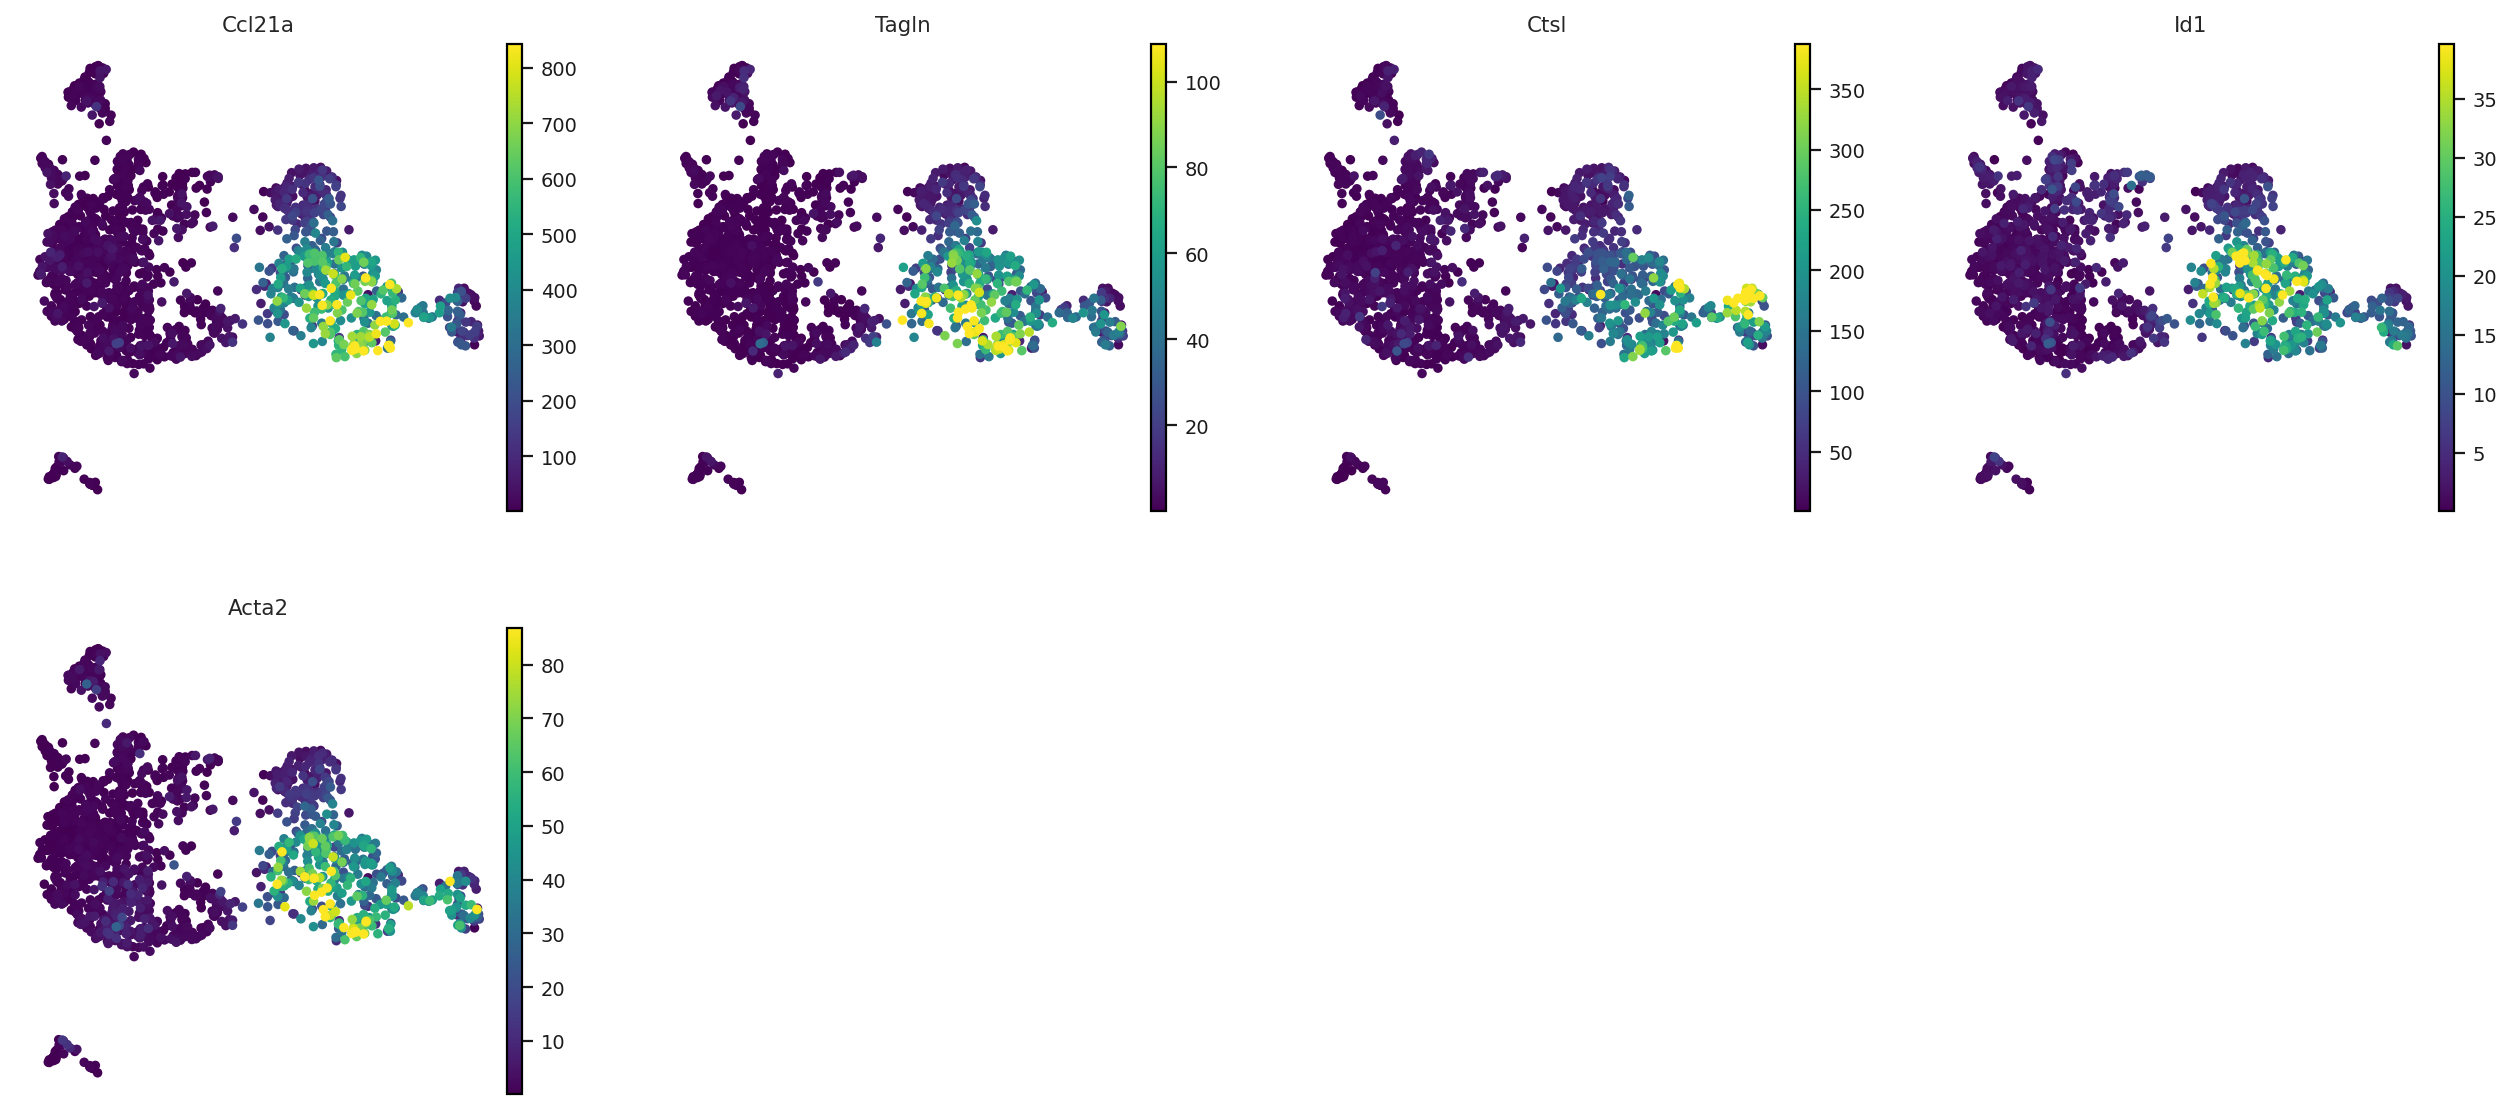

In [22]:
rna.pl.gene_embedding(
    adata[adata.obs.genotype == "WT"],
    deGenes["Aire+ mTECs"].head().index, # The top 5 DE genes for the Aire+ cluster
    layer="scVI_normalized", # can be a layer (i.e. 'raw_counts') or 'X'
    figsize = (4, 4), # size of each panel
    dpi = 80, # resolution of figure to show
    dpi_save = 300, # resolution of figure to save
    min_quantile = 0.01, # the quantile of expression for a gene to set the minimum of the colorbar to
    max_quantile = 0.99, # the quantile of expression for a gene to set the maximum of the colorbar to
    use_rep = "X_umap", # the embedding coordinates in 'adata.obsm' to use
    cmap="viridis",
)

### Condition vs control DE

You can also use scvi DE analysis to identify DE genes between samples (i.e. WT and KO) or across values in any other cell metadata ('obs') column.

In [23]:
de_df = model.differential_expression(
    groupby="genotype", group1="WT", group2="Fezf2_KO"
)

DE...: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


In [24]:
deFiltered = de_df[de_df.bayes_factor > 2]
deFiltered = deFiltered[(deFiltered.lfc_mean > 1) | (deFiltered.lfc_mean < -1)]
deFiltered = deFiltered[(deFiltered.non_zeros_proportion1 > 0.05) | (deFiltered.non_zeros_proportion2 > 0.05)]
deFiltered = deFiltered.sort_values(by="lfc_mean", ascending=False)

In [25]:
deFiltered

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
Fabp9      0.9748        0.0252      3.655388  0.000538  0.000048   
Cnnm1      0.9666        0.0334      3.365229  0.000102  0.000009   
Sorcs1     0.9680        0.0320      3.409496  0.000162  0.000051   
Tenm1      0.9692        0.0308      3.448956  0.000219  0.000047   
Mep1a      0.9600        0.0400      3.178054  0.000169  0.000053   
...           ...           ...           ...       ...       ...   
Snx31      0.9410        0.0590      2.769406  0.000025  0.000052   
Gm6209     0.9428        0.0572      2.802300  0.000086  0.000262   
Sprr2a3    0.9516        0.0484      2.978645  0.000275  0.000925   
Htr1f      0.9578        0.0422      3.122219  0.000028  0.000131   
Wfdc12     0.9578        0.0422      3.122219  0.000081  0.000308   

         pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  raw_mean1  \
Fabp9             0.0   0.25  4.757613    5.030519  3.811759  ...   3.989312   
Cnnm1             0.0   0.25  3.399353    3.473565  2.973114  ...   0.120546   
Sorcs1            0.0   0.25  3.201964    3.009718  5.390946  ...   0.535035   
Tenm1             0.0   0.25  3.124007    3.212780  4.496037  ...   0.381235   
Mep1a             0.0   0.25  2.802122    2.921371  3.341222  ...   0.517814   
...               ...    ...       ...         ...       ...  ...        ...   
Snx31             0.0   0.25 -1.990733   -2.024356  2.725688  ...   0.057007   
Gm6209            0.0   0.25 -2.052718   -2.040745  1.924396  ...   0.161520   
Sprr2a3           0.0   0.25 -2.175763   -2.207626  2.848488  ...   0.350950   
Htr1f             0.0   0.25 -2.552867   -2.633406  3.440425  ...   0.045131   
Wfdc12            0.0   0.25 -2.557459   -2.599288  3.660895  ...   0.271972   

         raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
Fabp9     0.127717               0.153207               0.022283   
Cnnm1     0.007065               0.058195               0.006522   
Sorcs1    0.071196               0.122922               0.028261   
Tenm1     0.053804               0.065321               0.021739   
Mep1a     0.166304               0.178741               0.063587   
...            ...                    ...                    ...   
Snx31     0.130435               0.031473               0.059239   
Gm6209    0.580434               0.064727               0.162500   
Sprr2a3   3.682622               0.041568               0.333696   
Htr1f     0.121739               0.029097               0.053261   
Wfdc12    1.141847               0.018409               0.095109   

         raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
Fabp9                6.568203              0.191988            True   
Cnnm1                0.286642              0.014784            True   
Sorcs1               1.076971              0.135876            True   
Tenm1                1.185379              0.100872            True   
Mep1a                1.020577              0.264585            True   
...                       ...                   ...             ...   
Snx31                0.107108              0.224099            True   
Gm6209               0.387904              1.131895            True   
Sprr2a3              0.884518             10.132827            True   
Htr1f                0.213486              0.492124            True   
Wfdc12               0.384113              2.172970            True   

             comparison  group1    group2  
Fabp9    WT vs Fezf2_KO      WT  Fezf2_KO  
Cnnm1    WT vs Fezf2_KO      WT  Fezf2_KO  
Sorcs1   WT vs Fezf2_KO      WT  Fezf2_KO  
Tenm1    WT vs Fezf2_KO      WT  Fezf2_KO  
Mep1a    WT vs Fezf2_KO      WT  Fezf2_KO  
...                 ...     ...       ...  
Snx31    WT vs Fezf2_KO      WT  Fezf2_KO  
Gm6209   WT vs Fezf2_KO      WT  Fezf2_KO  
Sprr2a3  WT vs Fezf2_KO      WT  Fezf2_KO  
Htr1f    WT vs Fezf2_KO      WT  Fezf2_KO  
Wfdc12   WT vs Fezf2_KO      WT  Fezf2_KO  

[352 rows x 22 colum

When generating feature plots of genes DE between WT and KO samples, I like to set the colorbar min/max based on the quantiles of gene expression in the WT data, and then use the same colorbar min/max for the KO data. This makes it more obvious when genes are expressed higher in one sample than another.

WT


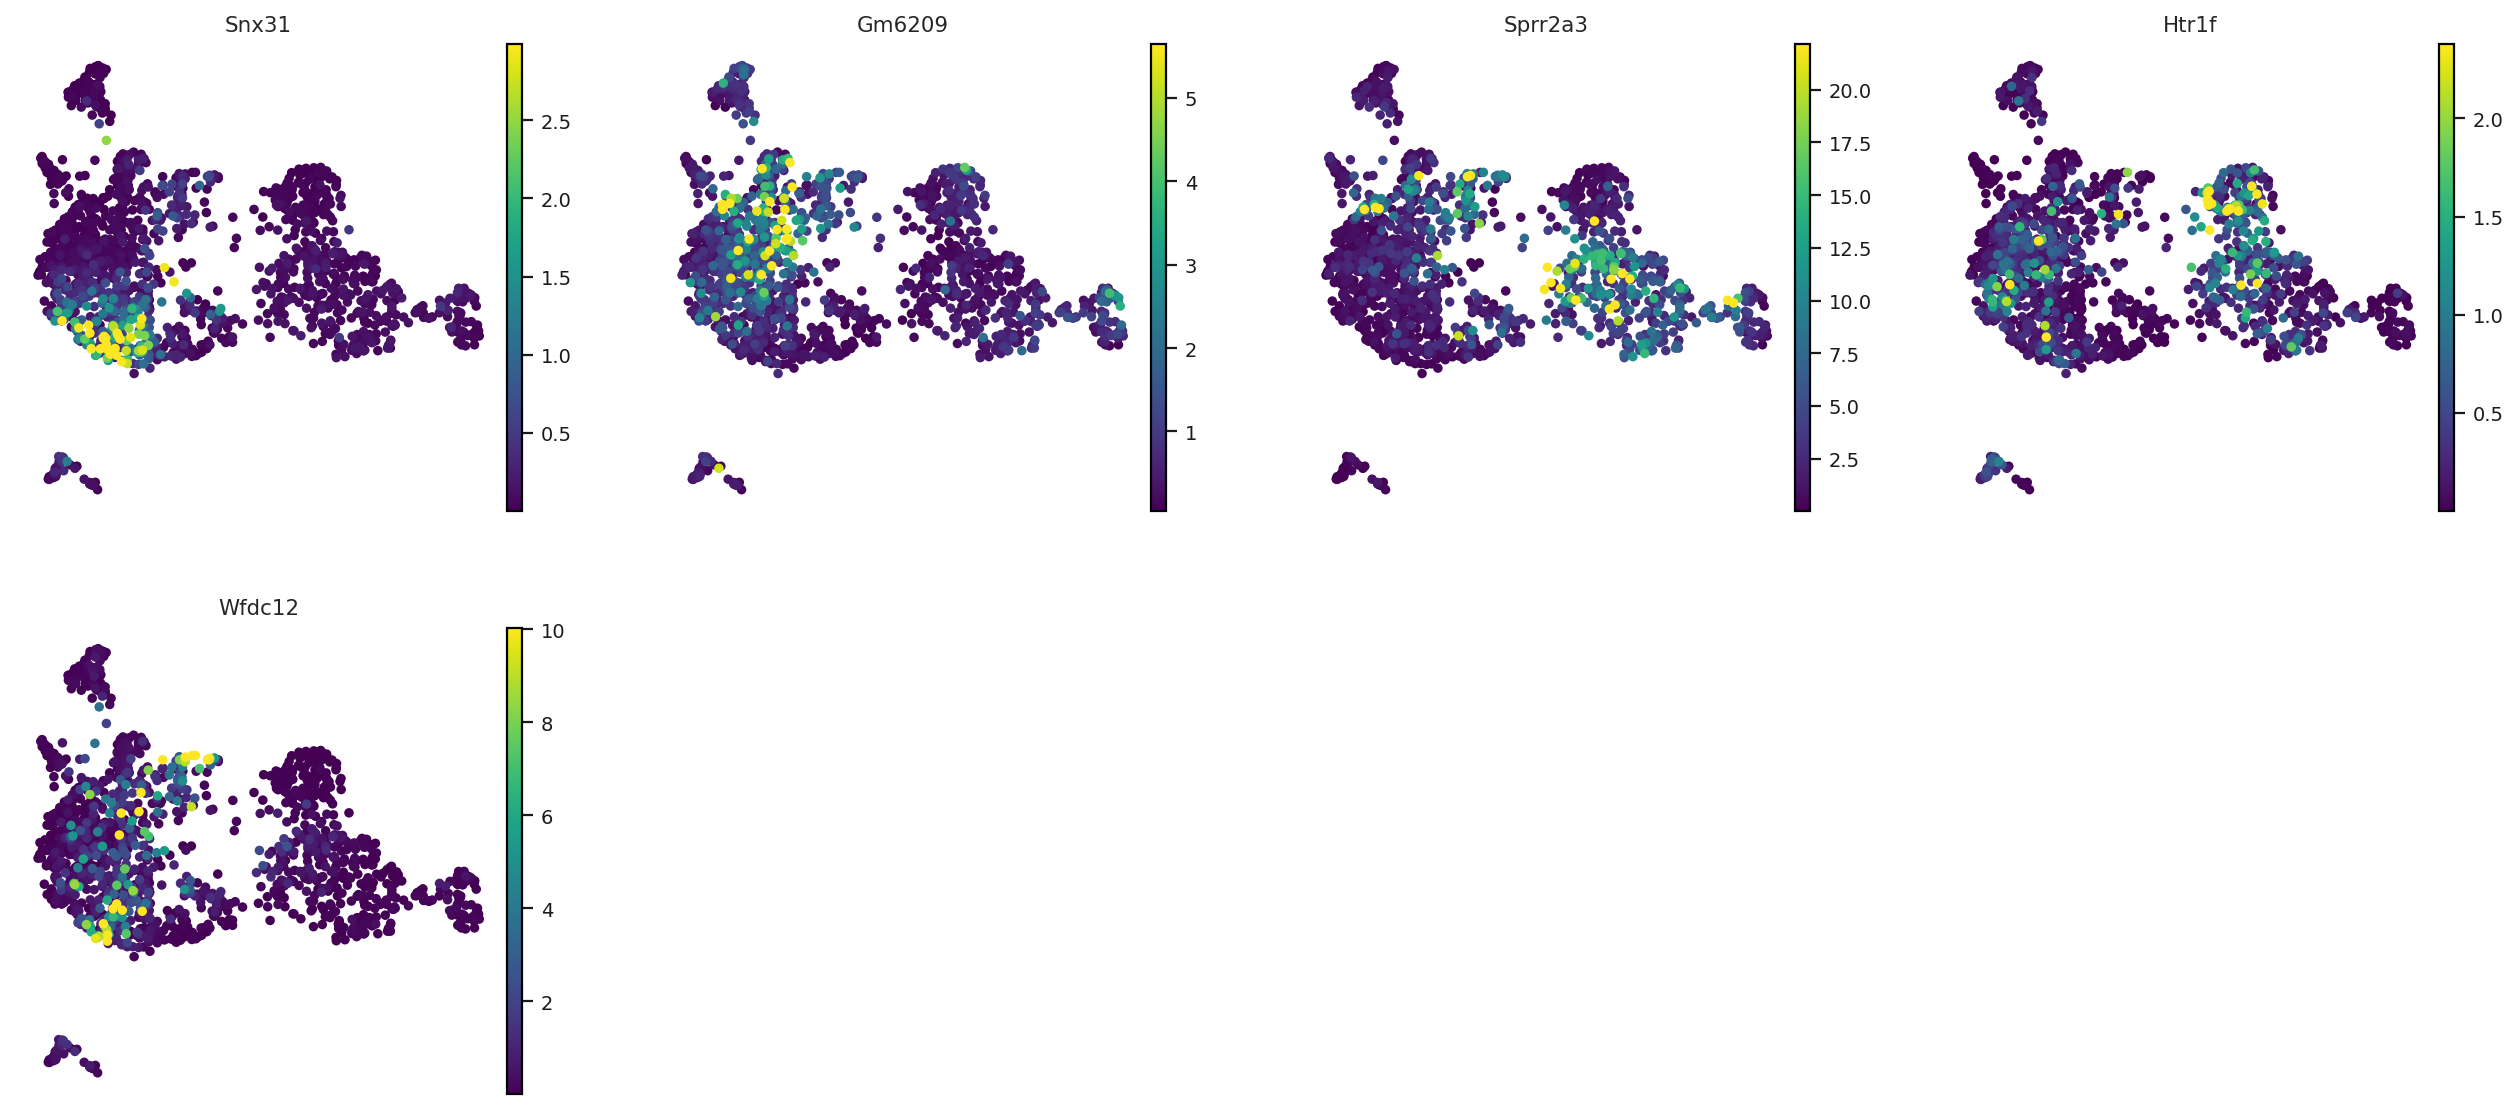

Fezf2_KO


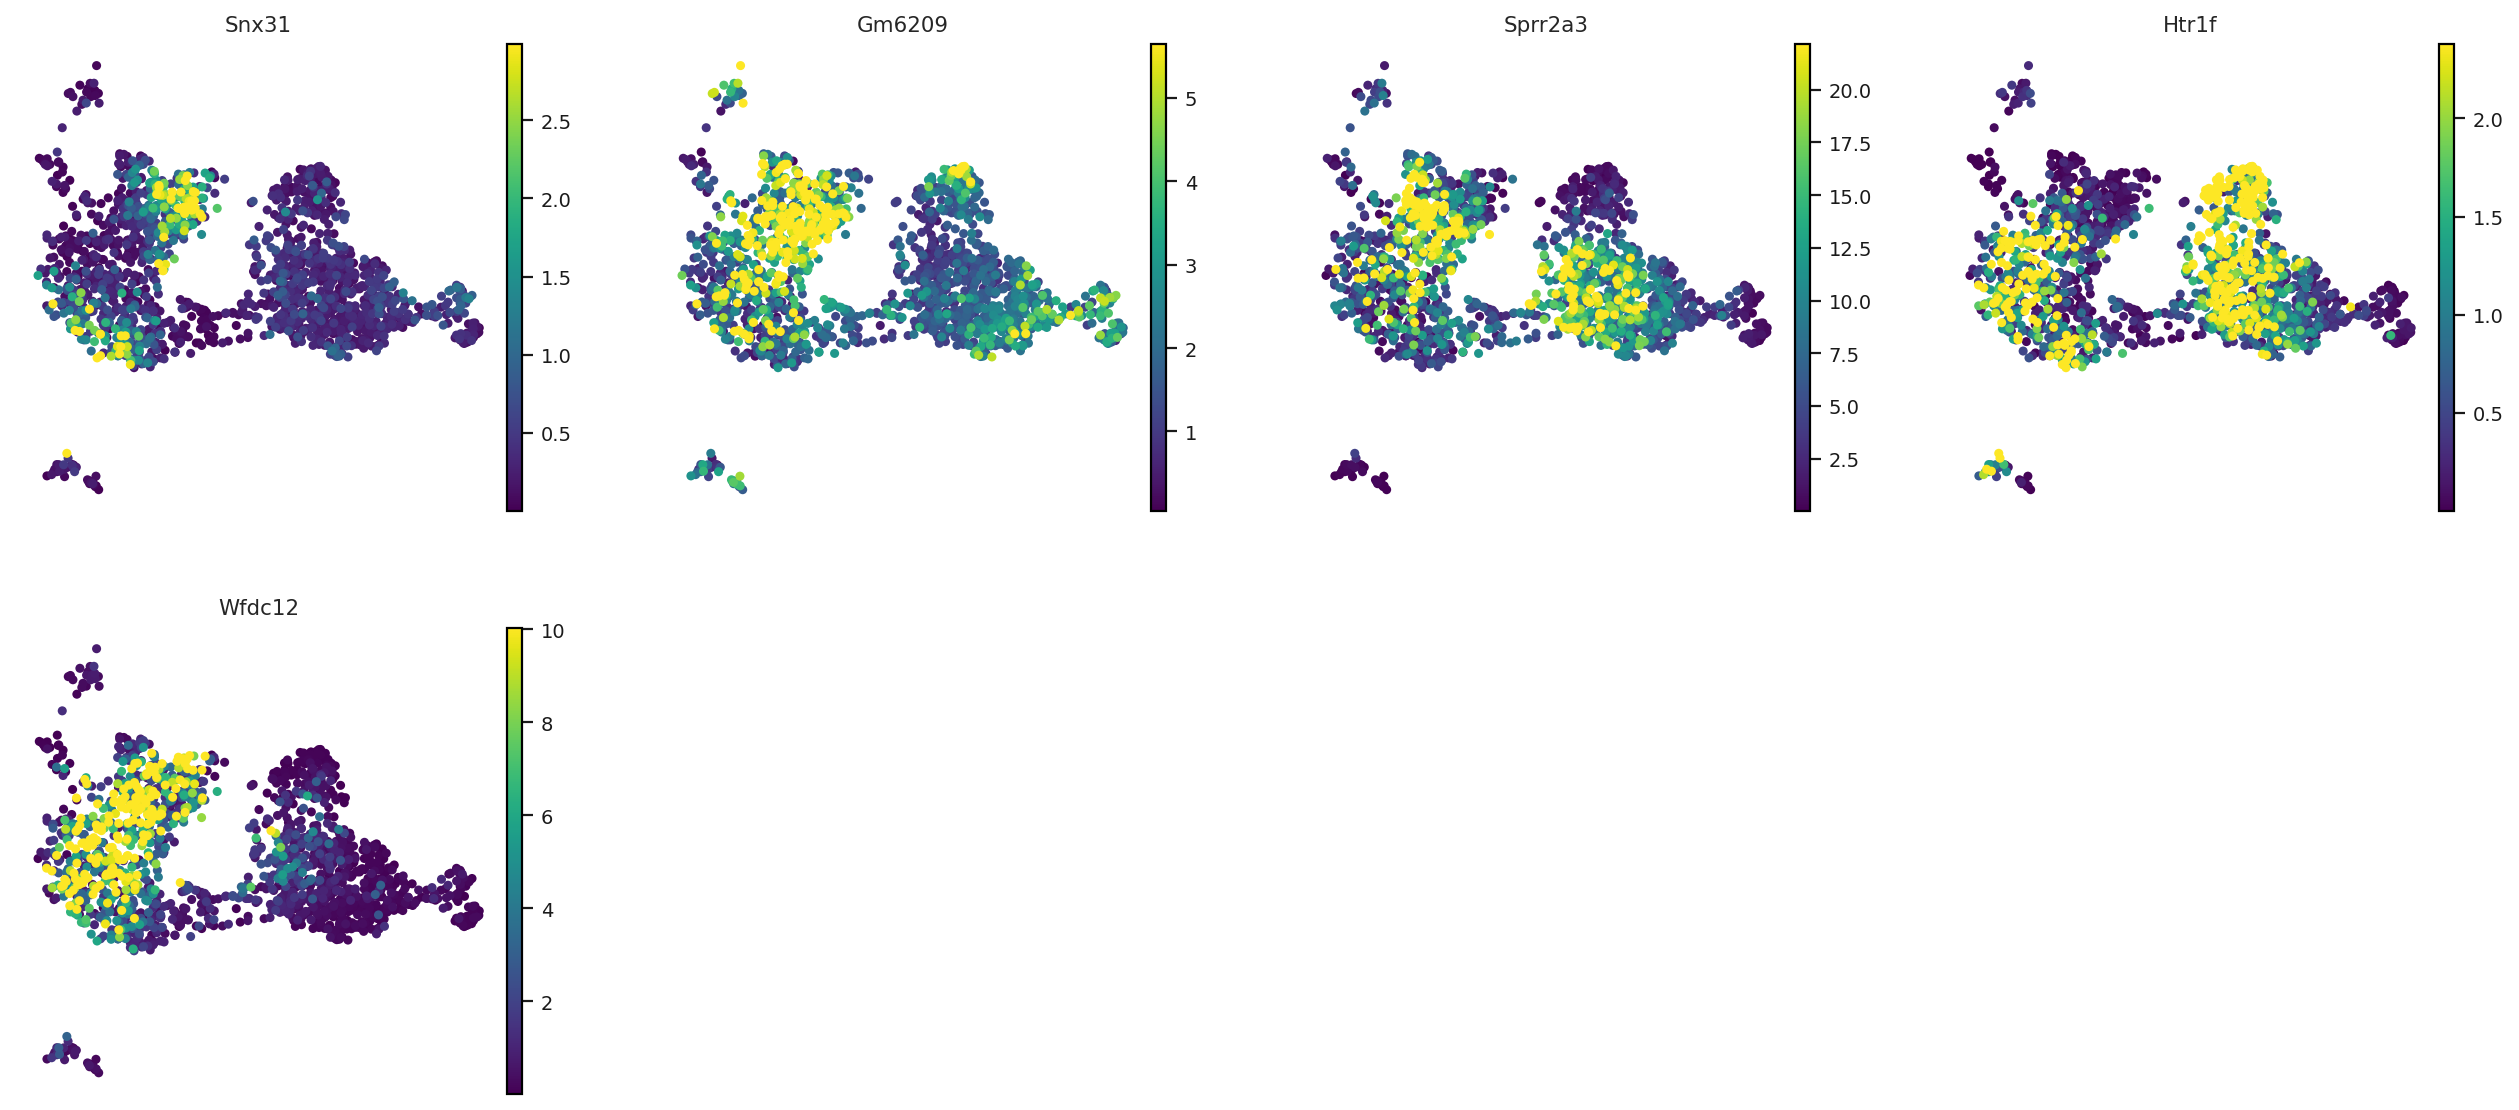

In [26]:
geneList = deFiltered.tail().index

vmin = []
vmax = []
for gene in geneList: # For each gene to plot
    expressionData = adata[adata.obs.genotype == "WT", gene].layers["scVI_normalized"] # Get the WT expression data
    vmin.append(np.quantile(expressionData, 0.01)) # get the 1st percentile of gene expression in the WT data
    vmax.append(np.quantile(expressionData, 0.99)) # get the 99th percentile of gene expression in the WT data
    
print("WT")
# Plot the gene exprssion in the WT data
sc.pl.umap(
    adata[adata.obs.genotype == "WT"],
    color=geneList,
    layer="scVI_normalized",
    vmin=vmin,
    vmax=vmax,
    cmap="viridis",
)

print("Fezf2_KO")
# Plot the gene exprssion in the KO data
sc.pl.umap(
    adata[adata.obs.genotype == "Fezf2_KO"],
    color=geneList,
    layer="scVI_normalized",
    vmin=vmin,
    vmax=vmax,
    cmap="viridis",
)

WT


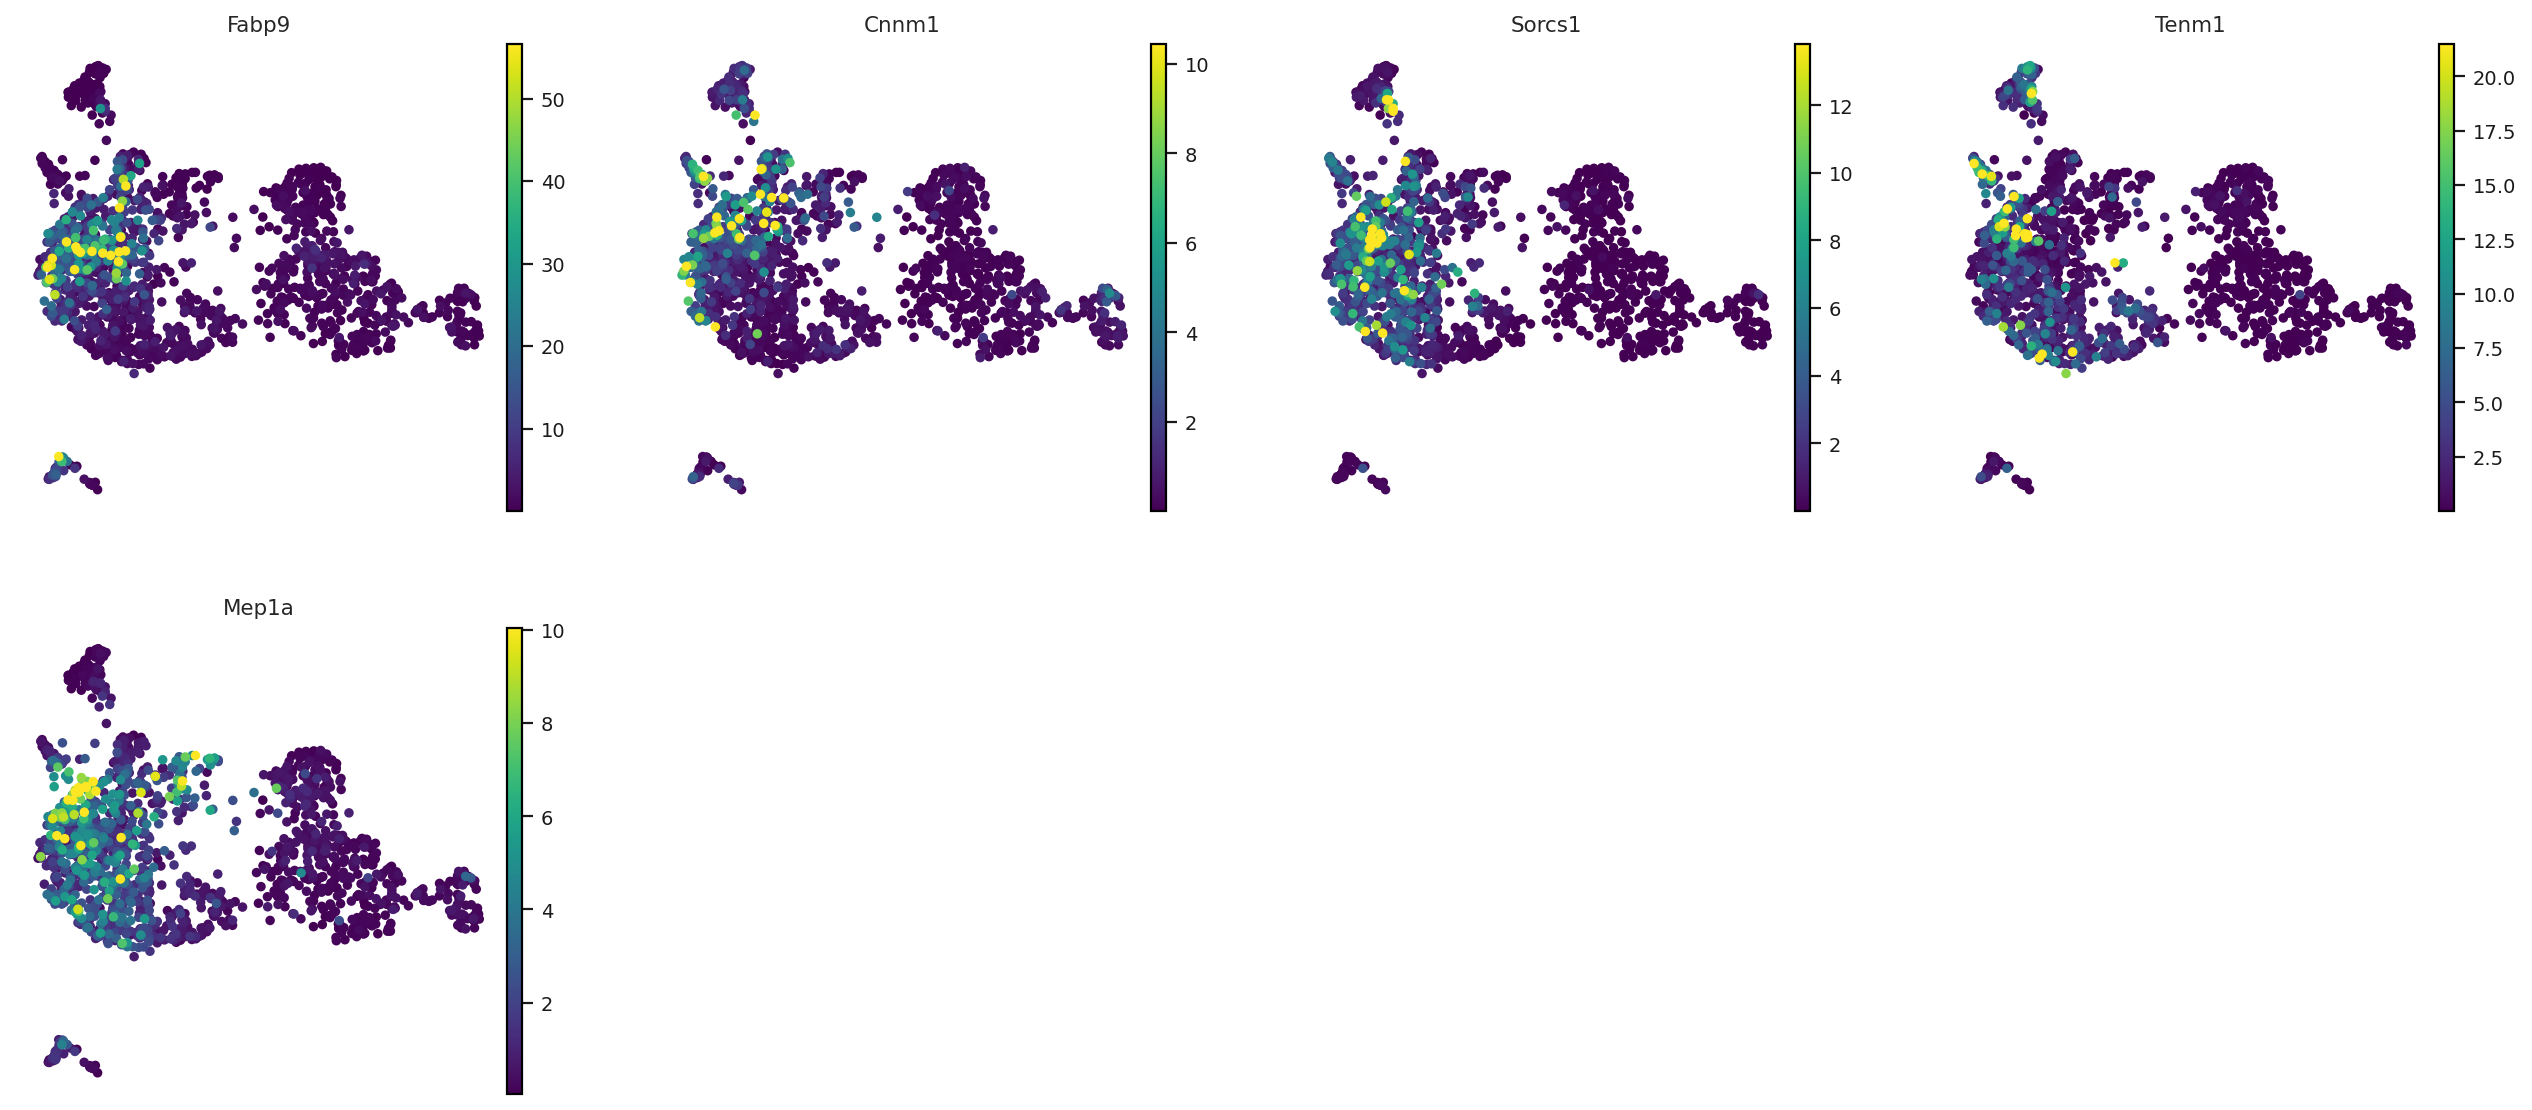

Fezf2_KO


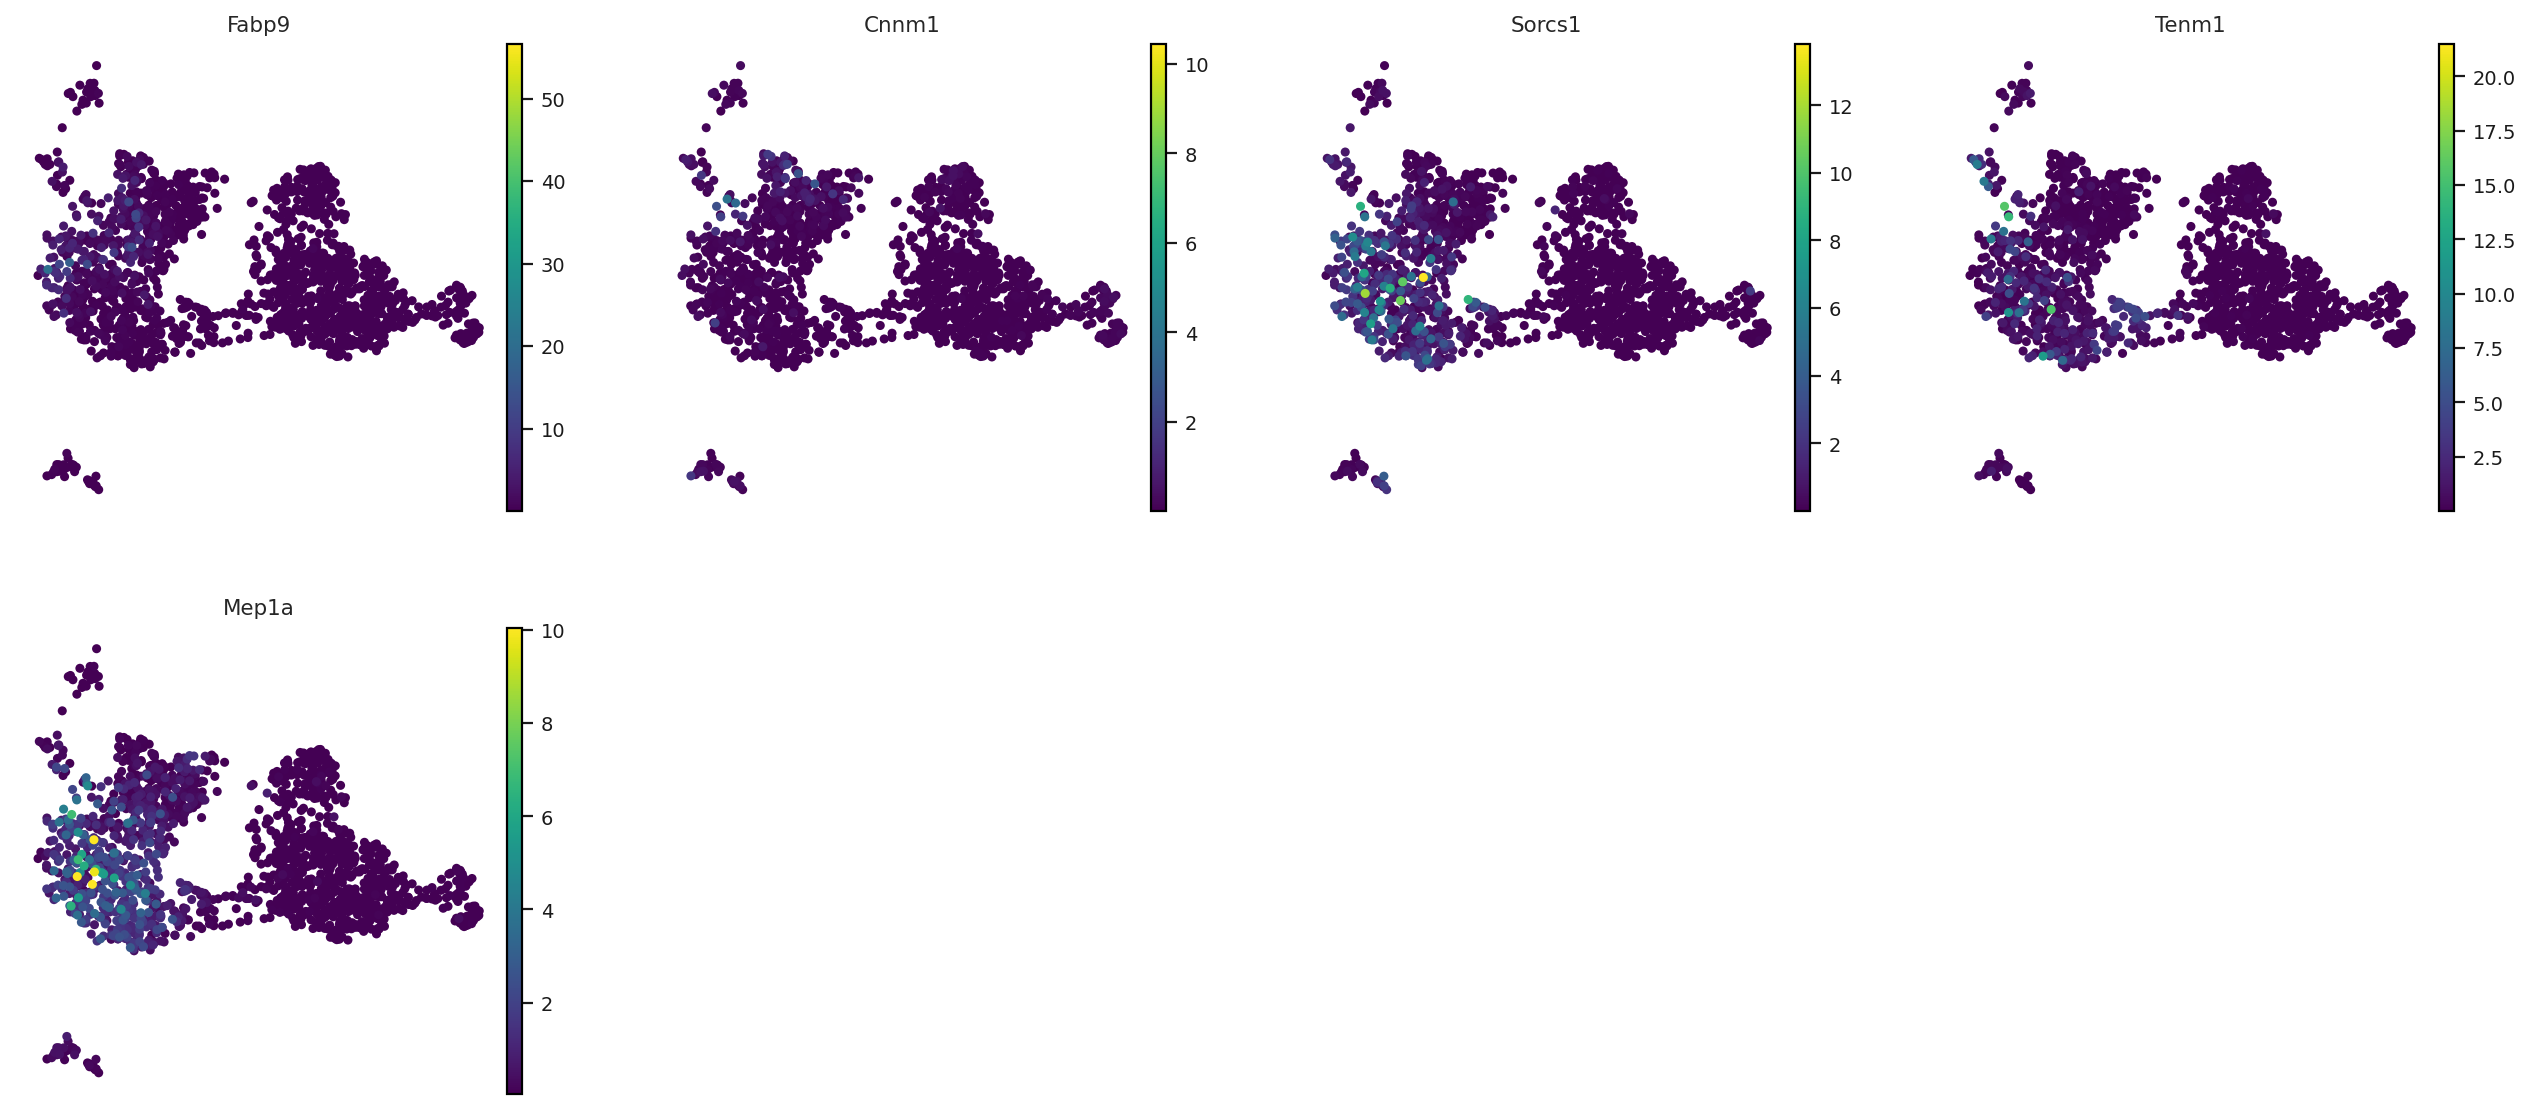

In [27]:
geneList = deFiltered.head().index

vmin = []
vmax = []
for gene in geneList:
    expressionData = adata[adata.obs.genotype == "WT", gene].layers["scVI_normalized"]
    vmin.append(np.quantile(expressionData, 0.01))
    vmax.append(np.quantile(expressionData, 0.99))
    
print("WT")
sc.pl.umap(
    adata[adata.obs.genotype == "WT"],
    color=geneList,
    layer="scVI_normalized",
    vmin=vmin,
    vmax=vmax,
    cmap="viridis",
)

print("Fezf2_KO")
sc.pl.umap(
    adata[adata.obs.genotype == "Fezf2_KO"],
    color=geneList,
    layer="scVI_normalized",
    vmin=vmin,
    vmax=vmax,
    cmap="viridis",
)

## Cell type identification with cosine similarity

Cosine similarity scoring allows each cell's expression to be compared with the expression signature of annotated cell types (for example from immgen) to assign a per cell score. This method can aid unbiased cell type identification by looking for annotated signatures with high scores in unknown cell types, and customm signatures can be created from published datasets (see scrnatools documentation)

In [28]:
immgen = rna.tl.get_immgen_similarity_signatures(save_path="data") 
immgen

SC_LT34F_BM  SC_LTSL_BM  SC_STSL_BM  SC_LTSL_FL  SC_STSL_FL  \
gene_name                                                                    
0610009B22Rik     6.797117    6.360333    6.662006    6.427335    6.437454   
0610009L18Rik     7.316544    8.168883    7.861428    7.800822    7.507517   
0610010F05Rik     7.400632    7.056768    7.160870    7.381136    7.572367   
0610010K14Rik     9.246308    9.295594    8.917933    9.367240    9.247446   
0610038B21Rik     5.861660    6.171731    5.818086    6.296947    6.031117   
...                    ...         ...         ...         ...         ...   
Zyx               9.272275   10.091382   10.290411    9.686166    9.693199   
Zzef1             8.120165    8.430231    8.487346    8.168742    8.455237   
Zzz3              9.536164    9.641560    9.469255    9.798141    9.703494   
a                 5.520124    5.760825    5.634933    5.677618    5.378890   
ccdc198           3.771157    3.787923    3.785655    4.234884    3.712354   

               SC_MPP34F_BM  SC_ST34F_BM  SC_CMP_BM  SC_MEP_BM  SC_GMP_BM  \
gene_name                                                                   
0610009B22Rik      6.679156     6.790981   6.943933   7.635508   7.117373   
0610009L18Rik      7.541081     7.455853   7.620293   7.114336   7.677924   
0610010F05Rik      7.270314     7.473560   7.626782   7.475628   6.164643   
0610010K14Rik      9.598990     9.599037   9.286498   9.292842  10.031798   
0610038B21Rik      6.096877     5.932255   6.636587   6.368213   6.342167   
...                     ...          ...        ...        ...        ...   
Zyx                9.263065     9.275447   9.290837   7.203798   9.167604   
Zzef1              7.849267     8.083128   8.474797   8.285157   7.571358   
Zzz3               9.309358     9.564820   9.540835   9.438682   7.894254   
a                  5.730925     5.401839   5.878863   5.765193   6.025753   
ccdc198            3.636079     3.795019   4.211293   3.862352   3.954699   

               ...  Ep_MEChi_Th  Fi_MTS15+_Th     Fi_Sk   FRC_MLN   FRC_SLN  \
gene_name      ...                                                            
0610009B22Rik  ...     6.476976      6.609829  6.502716  6.731251  6.780717   
0610009L18Rik  ...     7.996490      7.452834  7.537444  7.763949  7.545011   
0610010F05Rik  ...     7.275631      6.908525  6.612712  5.439932  6.098217   
0610010K14Rik  ...     8.417190      8.377814  9.693119  8.777117  8.631075   
0610038B21Rik  ...     6.041710      5.763672  6.043463  6.192078  5.952597   
...            ...          ...           ...       ...       ...       ...   
Zyx            ...     7.627300      8.744558  9.711825  9.024311  8.776755   
Zzef1          ...     7.780487      8.307825  7.919775  7.882258  8.075704   
Zzz3           ...     8.883996      9.326355  8.868233  8.466615  8.921892   
a              ...     6.150237      5.815616  6.151968  5.866124  5.811928   
ccdc198        ...     4.267858      3.852029  3.903250  3.839022  4.050693   

                LEC_MLN   LEC_SLN   BEC_MLN   BEC_SLN  St_31-38-44-_SLN  
gene_name                                                                
0610009B22Rik  6.816932  7.149442  6.942866  6.996807          6.529115  
0610009L18Rik  7.574276  7.177180  7.643272  7.463900          7.600032  
0610010F05Rik  6.716511  7.119968  6.492121  6.728206          6.356234  
0610010K14Rik  9.212467  9.399297  9.395945  9.408379          8.609123  
0610038B21Rik  5.838795  5.687346  6.040654  5.863289          6.197374  
...                 ...       ...       ...       ...               ...  
Zyx            9.386212  9.366995  9.160313  9.040734          9.292802  
Zzef1          8.389248  8.321919  8.261564  8.307784          7.852217  
Zzz3           8.794250  9.027696  8.824545  8.883593          8.514935  
a              5.712874  5.506494  5.755430  5.704714          5.938156  
ccdc198        3.749781  3.735544  3.919798  3.884754          3.845179  

[19264 

In [29]:
adata=rna.tl.cell_type_similarity(
    adata,
    signatures=immgen, # The gene x cell type DataFrame containing cell type signatures for scoring
)

In [30]:
# List all similarity scores
[i for i in adata.obs.columns if "cosine_similarity" in i]

['SC_LT34F_BM_cosine_similarity_cell_z_score',
 'SC_LTSL_BM_cosine_similarity_cell_z_score',
 'SC_STSL_BM_cosine_similarity_cell_z_score',
 'SC_LTSL_FL_cosine_similarity_cell_z_score',
 'SC_STSL_FL_cosine_similarity_cell_z_score',
 'SC_MPP34F_BM_cosine_similarity_cell_z_score',
 'SC_ST34F_BM_cosine_similarity_cell_z_score',
 'SC_CMP_BM_cosine_similarity_cell_z_score',
 'SC_MEP_BM_cosine_similarity_cell_z_score',
 'SC_GMP_BM_cosine_similarity_cell_z_score',
 'SC_CDP_BM_cosine_similarity_cell_z_score',
 'SC_MDP_BM_cosine_similarity_cell_z_score',
 'MLP_BM_cosine_similarity_cell_z_score',
 'MLP_FL_cosine_similarity_cell_z_score',
 'proB_CLP_BM_cosine_similarity_cell_z_score',
 'proB_FrA_BM_cosine_similarity_cell_z_score',
 'proB_FrBC_BM_cosine_similarity_cell_z_score',
 'preB_FrC_BM_cosine_similarity_cell_z_score',
 'preB_FrD_BM_cosine_similarity_cell_z_score',
 'B_FrE_BM_cosine_similarity_cell_z_score',
 'proB_CLP_FL_cosine_similarity_cell_z_score',
 'proB_FrA_FL_cosine_similarity_cell_z

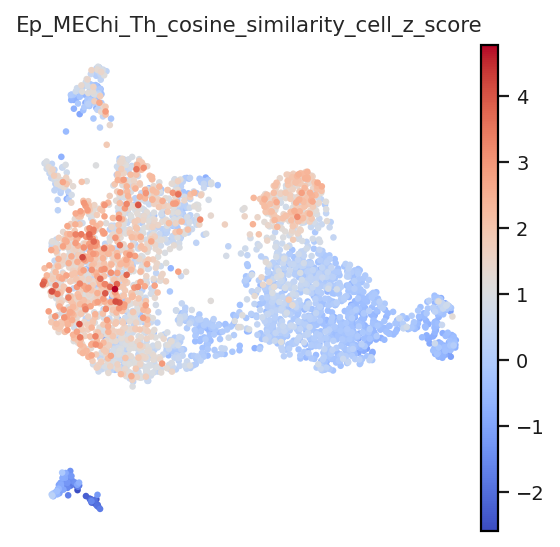

In [31]:
# Plot a similarity score on a UMAP
sc.pl.umap(
    adata,
    color=["Ep_MEChi_Th_cosine_similarity_cell_z_score"],
    cmap="coolwarm",
)

## Differential density plotting

Differential density ploting highlights regions of a UMAP/TSNE that are enriched for cells from one sample vs another sample (ie. WT vs KO), allowing for differences in the cell type composition of samples to be visualized. However, beecause this analysis is based on interpreting cell to cell differences in UMAP space, any preliminary results using this method *MUST* be validated using an orthogonal experimental approach, i.e. flow cytometry.

In [32]:
adata = rna.tl.log_density_ratio(
    adata,
    group_by="genotype", # The column in adata.obs containing condition/control labels
    groups=["WT", "Fezf2_KO"], # The condition/control labels in adata.obs[group_by] to use
    latent_rep="X_umap", # The latent representation to calculate density over
    key_added="KO/WT_log_density_ratio", # The column to add to adta.obs with the differential density ratio
)

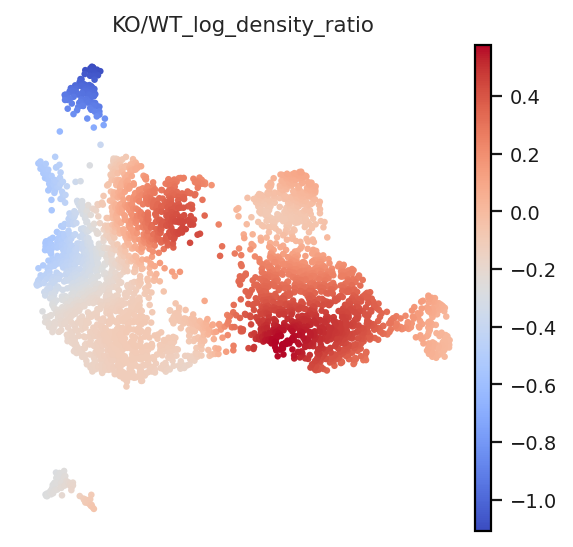

In [33]:
sc.pl.umap(
    adata,
    color="KO/WT_log_density_ratio",
    cmap="coolwarm",
)

## Other helpful tools

### Extract expression data

In [34]:
# Returns a cell x gene DataFrame with expression data from 'adata.X' 'adata.raw' or a layer in 'adata.layers'
data = rna.tl.get_expression_matrix(
    adata,
    "scVI_normalized", # Can be 'X', 'raw', or a layer in 'adata.layers'
)
data

Xkr4       Rp1      Rgs20        St18  \
CATTGCCTCACGAACT-1-WT        4.698067  1.406280   5.230187    0.456192   
CTCTGGTAGCTTTCTT-1-WT        4.227992  0.167570   2.030662    0.853111   
GTCCTCATCGGTGCAC-1-WT        2.489564  9.775109  12.549826    0.493004   
GGTGAAGCATCTATCT-1-WT        3.254163  0.047129   1.728318    0.318939   
TCCACGTTCGTTCTCG-1-WT        6.955166  0.096924   1.940480  106.558151   
...                               ...       ...        ...         ...   
TGCATCCGTGTATACC-1-Fezf2_KO  0.424917  0.007876   0.230571    0.045226   
ATACCTTCACCCAACG-1-Fezf2_KO  1.576926  0.002797   1.881303    0.222383   
TGAGGGATCTGCCTCA-1-Fezf2_KO  4.089052  0.002685   0.541098    0.102116   
GAGTTACGTGCGTCGT-1-Fezf2_KO  0.375557  0.011759   0.225462    0.013061   
TGATGGTGTGCATCTA-1-Fezf2_KO  6.149090  0.003396   0.563213    0.154413   

                                Sntg1  1700034P13Rik      Sgk3     Tcf24  \
CATTGCCTCACGAACT-1-WT        2.812503       1.423576  4.171987  0.467164   
CTCTGGTAGCTTTCTT-1-WT        2.513081       0.487119  1.433361  1.751384   
GTCCTCATCGGTGCAC-1-WT        0.794611       1.745046  3.744724  0.858356   
GGTGAAGCATCTATCT-1-WT        3.615078       0.154376  0.439570  0.005180   
TCCACGTTCGTTCTCG-1-WT        3.706280       0.154163  4.331223  0.345769   
...                               ...            ...       ...       ...   
TGCATCCGTGTATACC-1-Fezf2_KO  1.622571       0.971027  1.899249  0.014609   
ATACCTTCACCCAACG-1-Fezf2_KO  1.327570       0.015326  2.179114  1.923204   
TGAGGGATCTGCCTCA-1-Fezf2_KO  2.869735       0.030875  2.881617  0.056874   
GAGTTACGTGCGTCGT-1-Fezf2_KO  4.681602       0.322690  0.507825  0.000822   
TGATGGTGTGCATCTA-1-Fezf2_KO  2.713124       0.086826  5.657403  0.014579   

                                 Cpa6     Prex2  ...     Asb11      Gpm6b  \
CATTGCCTCACGAACT-1-WT        0.152603  0.245625  ...  0.824509   0.569941   
CTCTGGTAGCTTTCTT-1-WT        0.201517  0.104414  ...  1.182720   1.540915   
GTCCTCATCGGTGCAC-1-WT        0.525393  0.078345  ...  0.595682   0.175142   
GGTGAAGCATCTATCT-1-WT        0.016315  0.209688  ...  0.081890   0.103993   
TCCACGTTCGTTCTCG-1-WT        1.030505  0.098627  ...  1.059316   0.264889   
...                               ...       ...  ...       ...        ...   
TGCATCCGTGTATACC-1-Fezf2_KO  0.007370  0.888215  ...  0.100958   0.304867   
ATACCTTCACCCAACG-1-Fezf2_KO  0.002704  0.267691  ...  0.012216   1.306253   
TGAGGGATCTGCCTCA-1-Fezf2_KO  0.007790  0.433509  ...  0.006633   3.167266   
GAGTTACGTGCGTCGT-1-Fezf2_KO  0.032666  1.930380  ...  3.567202   0.319924   
TGATGGTGTGCATCTA-1-Fezf2_KO  0.027408  1.634237  ...  0.015240  11.999697   

                                Egfl6      Tmsb4x     Frmpd4    Arhgap6  \
CATTGCCTCACGAACT-1-WT        0.124263   67.378181   6.212284   0.731842   
CTCTGGTAGCTTTCTT-1-WT        0.085271  159.959122   1.268056   0.339190   
GTCCTCATCGGTGCAC-1-WT        0.024151   44.961903   5.153682   0.374129   
GGTGAAGCATCTATCT-1-WT        0.007728  221.018738   2.102364   2.409496   
TCCACGTTCGTTCTCG-1-WT        0.003516   28.403774  51.962563   0.826601   
...                               ...         ...        ...        ...   
TGCATCCGTGTATACC-1-Fezf2_KO  0.241989  291.478119   5.977501   0.564008   
ATACCTTCACCCAACG-1-Fezf2_KO  0.345745  157.584473   2.182439   3.329881   
TGAGGGATCTGCCTCA-1-Fezf2_KO  0.031971  192.472900   1.317302   5.057658   
GAGTTACGTGCGTCGT-1-Fezf2_KO  0.253479  466.839996   0.948342   1.071198   
TGATGGTGTGCATCTA-1-Fezf2_KO  0.204694  255.507172  10.920515  14.886935   

                                 Amelx   Gm47283  AC168977.1  CR974586.4  
CATTGCCTCACGAACT-1-WT         1.694398  4.118850    0.077717    1.482590  
CTCTGGTAGCTTTCTT-1-WT         0.090765  5.657679    0.045580    0.528939  
GTCCTCATCGGTGCAC-1-WT         0.031017  2.970359    1.788395    0.322665  
GGTGAAGCATCTATCT-1-WT         0.149778  6.159513    0.029938    0.917458  
TCCACGTTCGTTCTCG-1-WT         

### Gene set enrichment scores

Scanpy has a method that allows you to provide a list of genes that it then uses to score cells based on their enrichment of expression of genes from that list versus all other genes.

In [35]:
TRAs = pd.read_csv("/content/gdrive/MyDrive/scrnaseq-course/data/TRA_list.csv", index_col=0)
TRAs

0
0           Xkr4
1            Rp1
2          Sox17
3          Oprk1
4         Npbwr1
...          ...
4934      Ube1y1
4935  ERCC-00041
4936  ERCC-00085
4937  ERCC-00117
4938  ERCC-00143

[4939 rows x 1 columns]

In [36]:
TRAs = TRAs["0"].tolist()
TRAs

['Xkr4',
 'Rp1',
 'Sox17',
 'Oprk1',
 'Npbwr1',
 'St18',
 'Sntg1',
 '3110035E14Rik',
 'Ppp1r42',
 'Cpa6',
 'Sulf1',
 'Prdm14',
 'Xkr9',
 'Gm5523',
 'Msc',
 'Trpa1',
 'Kcnb2',
 'Gdap1',
 'Pi15',
 'Tfap2b',
 'Pkhd1',
 'Il17a',
 '6720483E21Rik',
 'Gsta3',
 'Khdc1a',
 'Rims1',
 'Mir30c-2',
 'Col9a1',
 'Bai3',
 'Gm20172',
 'Khdrbs2',
 'Gm5415',
 'Gm15455',
 'Bend6',
 'Cfc1',
 'Fam123c',
 'Zap70',
 'Lyg1',
 'Lonrf2',
 'Creg2',
 'Rfx8',
 'Il1r2',
 'Il18rap',
 'Slc9a2',
 'Tmem182',
 '2610017I09Rik',
 'Pou3f3',
 '2900092D14Rik',
 'Gpr45',
 '1500015O10Rik',
 '4832428D23Rik',
 'Col3a1',
 'Tmeff2',
 'Boll',
 '9130227L01Rik',
 'Satb2',
 'Aox3',
 'Aox4',
 'Als2cr12',
 'Gm973',
 'Cd28',
 'Ctla4',
 'Zdbf2',
 'Mdh1b',
 'Gm13749',
 'Akr1cl',
 'D630023F18Rik',
 'Unc80',
 'Myl1',
 'Cps1',
 'Erbb4',
 'Spag16',
 'Vwc2l',
 'Abca12',
 'Gm8883',
 '4933417E11Rik',
 'Tmem169',
 'March4',
 'Igfbp2',
 'Pinc',
 '6030407O03Rik',
 'Rufy4',
 'Cxcr2',
 'Cxcr1',
 'Slc11a1',
 'Vil1',
 'Wnt10a',
 'Cdk5r2',
 'Fev',
 'Cryba

In [37]:
TRAs = [i for i in TRAs if i in adata.var_names]

In [38]:
sc.tl.score_genes(
    adata,
    gene_list=TRAs, # The list of genes to score each cell's enrichment of expression of
    use_raw=True, # Always use log-transformed expression for this analysis
    score_name="TRA_score", # The column name of the score to be added to 'obs'
)

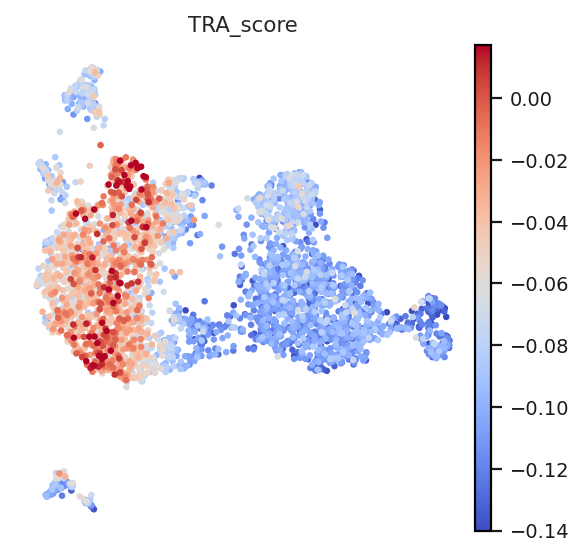

In [39]:
sc.pl.umap(
    adata,
    color="TRA_score",
    cmap="coolwarm",
    vmin=np.quantile(adata.obs.TRA_score, 0.01),
    vmax=np.quantile(adata.obs.TRA_score, 0.99),
)

### Cell cycle analysis

Scanpy also has a special gene list eenrichment scoring method that can be used to annotate th cell cycle phase of cells in a dataset based on published cell cycle genes.

In [40]:
# A published list of human S and G2M genes
cell_cycle_genes = list(pd.read_csv("/content/gdrive/MyDrive/scrnaseq-course/data/regev_lab_cell_cycle_genes.txt", header=None)[0]) 
# Convert to mouse gene names the easy way (lowercase for all letters but the first)
cell_cycle_genes = [i.capitalize() for i in cell_cycle_genes]
# Split into the S and G2M genes
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

In [41]:
sc.tl.score_genes_cell_cycle(adata, s_genes, g2m_genes)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


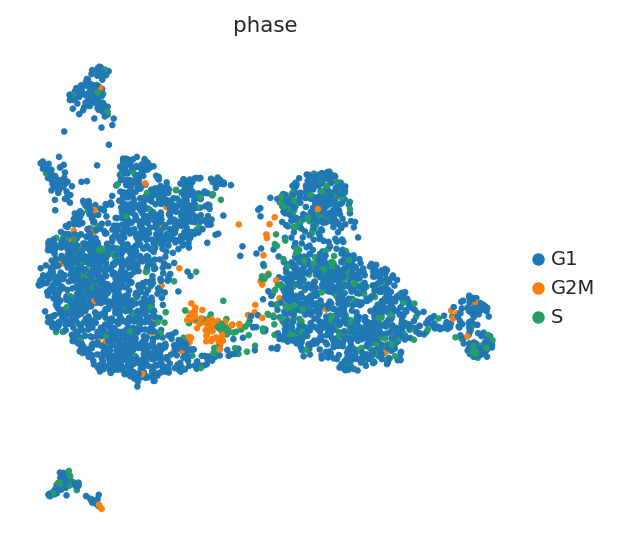

In [42]:
sc.pl.umap(
    adata,
    color="phase",
)

## Save data

In [43]:
adata.write("/content/gdrive/MyDrive/scrnaseq-course/data/scRNAseq_tutorial_thymus_data.h5ad")